# **CarND-Advanced-Lane-Lines** 
***


---

In [1]:
"""
Detecting line segments on single pictures and videos which have been made by a camera in a car. 
Programm: Udacity - Self Driving Car Engineer
Project: P4 - CarND-Advanced-Lane-Lines
Author: Daniel Gattringer (gada1982) 
"""

#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print_debug = 1



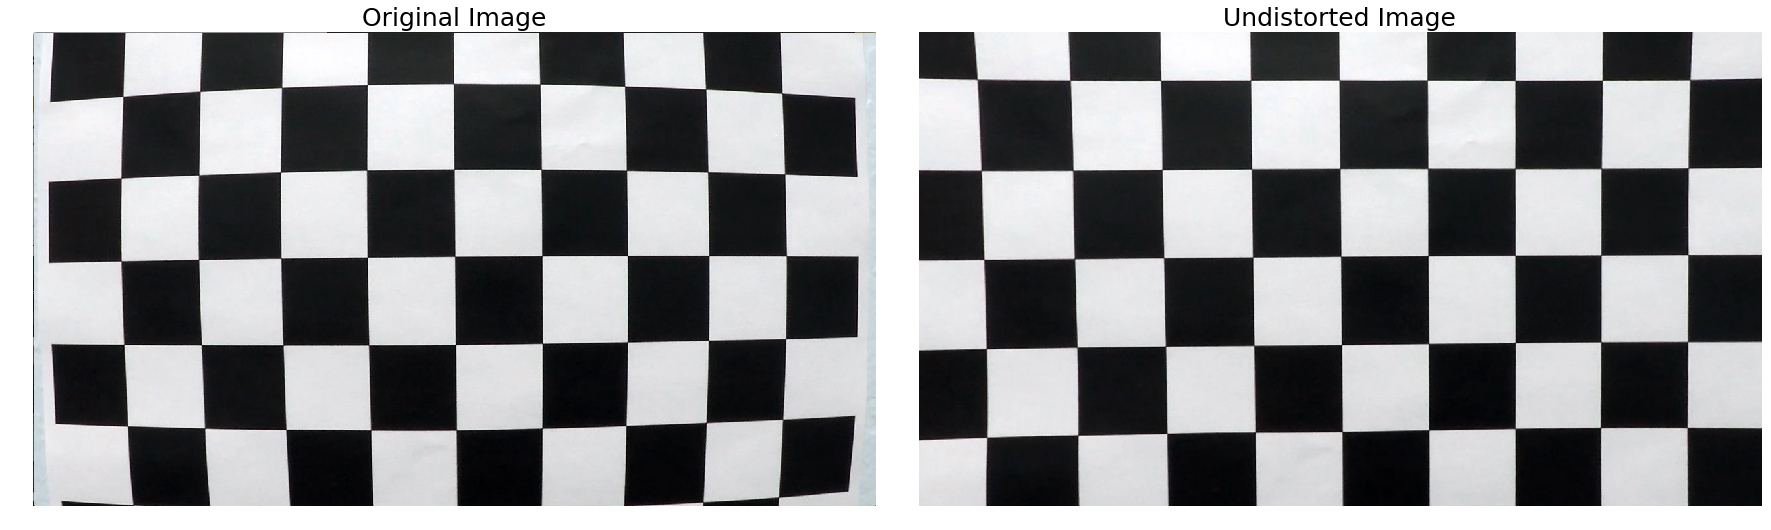

In [2]:
# Code taken from https://github.com/udacity/CarND-Camera-Calibration


def get_calibration_data():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = 'camera_cal_corners_found/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            
    return objpoints, imgpoints


def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


def plot_undistort_image(image):
    image_undist = cal_undistort(image, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(image_undist)
    ax2.set_title('Undistorted Image', fontsize=25)
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# Stores data for camera calibration locally
# TODO find a better solution
objpoints, imgpoints = get_calibration_data()
    
if print_debug == 1:    
    # Read in an image
    image = cv2.imread('camera_cal/calibration1.jpg')

    plot_undistort_image(image)

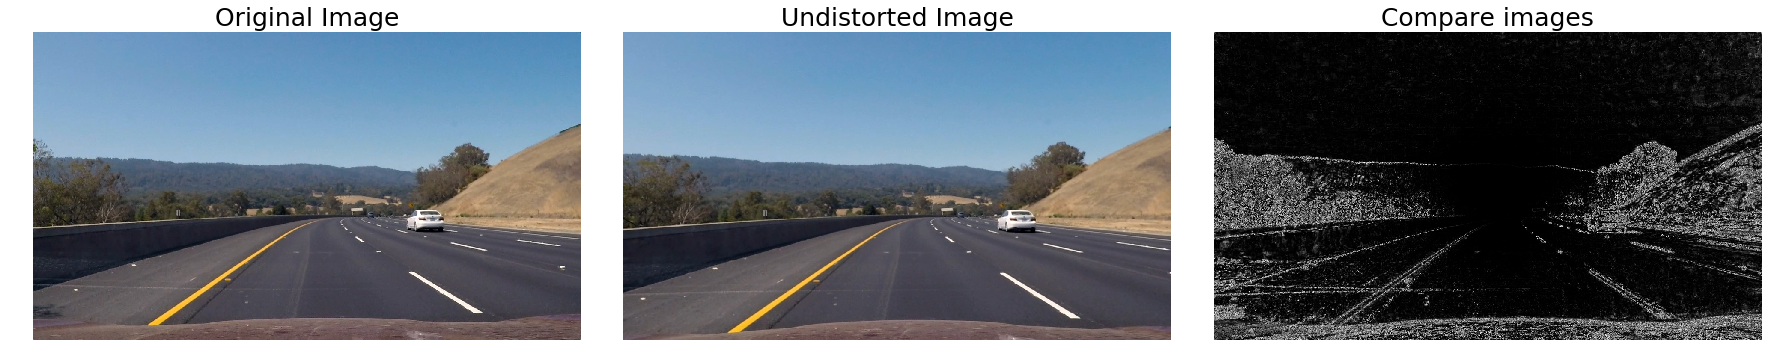

In [3]:
# Distort test_images

def plot_undistort_image_compare(image):
    
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(image_undist)
    ax2.axis('off')
    ax2.set_title('Undistorted Image', fontsize=25)
    ax3.imshow(np.sum((image - image_undist)**2,axis=2),cmap='gray')
    ax3.axis('off')
    ax3.set_title('Compare images', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')

    plot_undistort_image_compare(image)

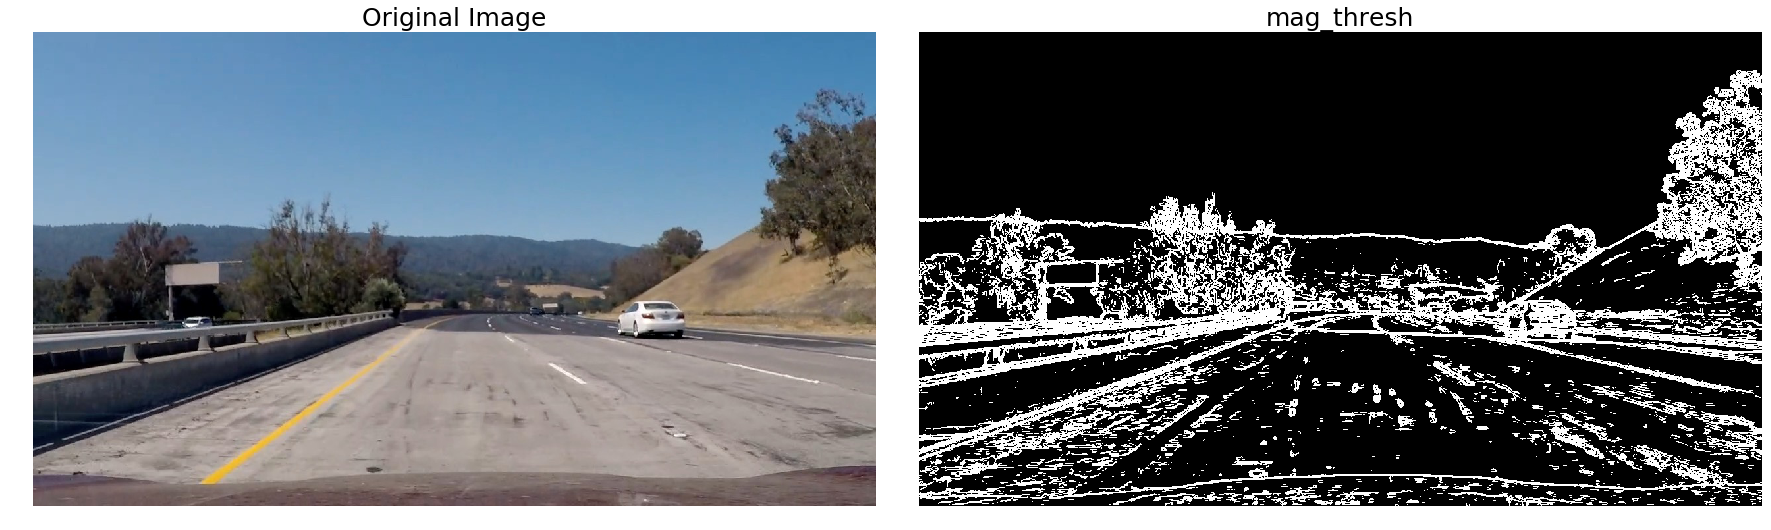

In [4]:
# Create a binary image for one image

# TODO not used
def apply_gaussian_blur(image, kernel):
    gaussian_blur_image = cv2.GaussianBlur(image,(kernel,kernel),0)
    return gaussian_blur_image


def mag_thresh(image, kernel, mag_thresh):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)     
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mag_binary


def plot_image_with_mag_tresh(image):
    image_undist = cal_undistort(image, objpoints, imgpoints)

    # Apply each of the thresholding functions
    mag_binary = mag_thresh(image_undist, 3, (10, 255))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(mag_binary, cmap='gray')
    ax2.axis('off')
    ax2.set_title('mag_thresh', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_mag_tresh(image)

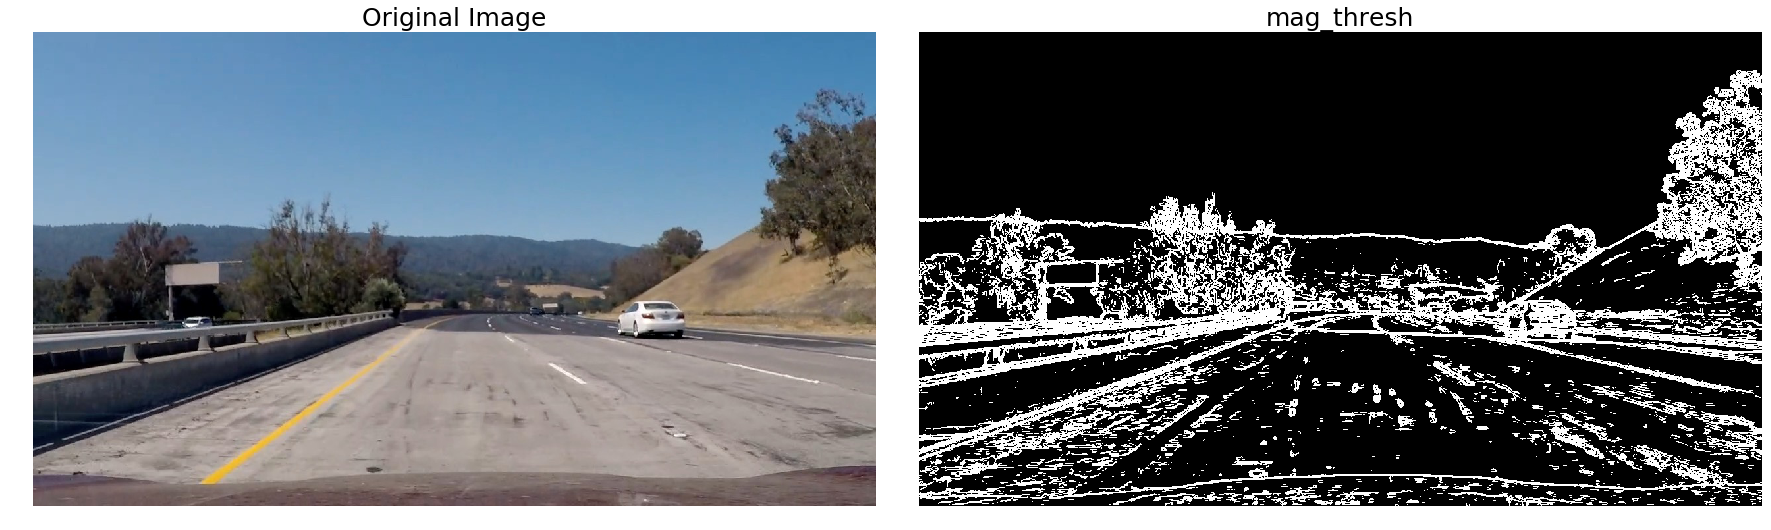

In [5]:

def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return grad_binary

def plot_image_with_abs_sobel_thresh(image):
    image_undist = cal_undistort(image, objpoints, imgpoints)

    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(filter_hls_l, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Abs Sobel', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_mag_tresh(image)

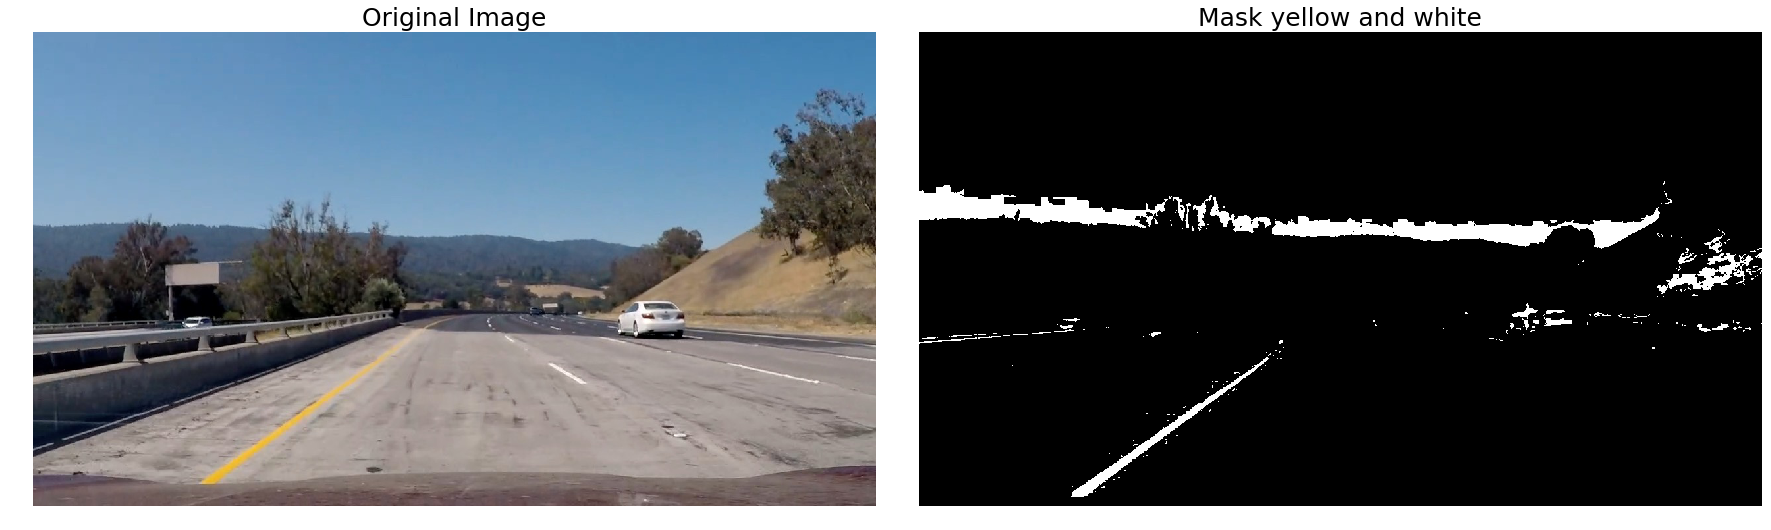

In [6]:
# Apply Color mask

def get_color_mask(img):
    
    image_hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    # White - TODO test different values
    hsv_white_l  = np.array([ 20,   0,   180])
    hsv_white_h = np.array([ 255,  80, 255])
    
    # Mask for white lanes
    mask_white = cv2.inRange(image_hsv, hsv_white_l, hsv_white_h)
    
    # Yellow - TODO test different values
    hsv_yellow_l  = np.array([ 0,  100,  100])
    hsv_yellow_h = np.array([ 50, 255, 255])
    
    # Mask for yellow lanes
    mask_yellow = cv2.inRange(image_hsv, hsv_yellow_l, hsv_yellow_h)
    
    mask_white_yellow = cv2.bitwise_or(mask_white, mask_yellow)
    
    return mask_white_yellow


def plot_image_with_color_mask(image):
    image_undist = cal_undistort(image, objpoints, imgpoints)

    mask_yellow_white = get_color_mask(image_undist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(mask_yellow_white, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Mask yellow and white', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    #image = mpimg.imread('test_images/test3.jpg')
    image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask(image)

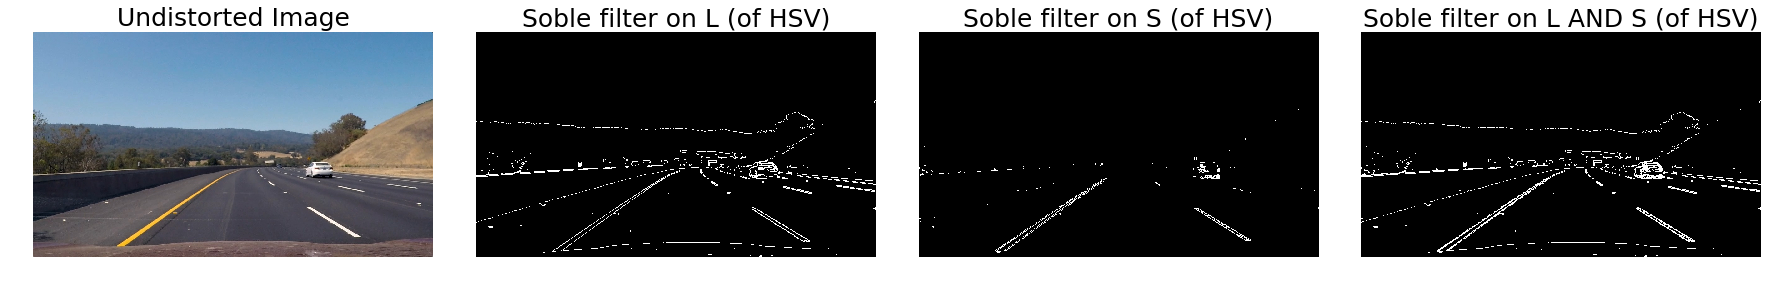

In [7]:
# Apply sobel filters
def get_sobel_mask(img):
    # Get image in HLS Color Space
    image_hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    
    # Get L channel
    image_hls_l = image_hls[:,:,1]
    ksize = 5
    thresh = (50,225)
    gradx = abs_sobel_thresh(image_hls_l, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_l, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_l = np.copy(cv2.bitwise_or(gradx, grady))
    
    # Get S channel
    image_hls_s = image_hls[:,:,2]
    gradx = abs_sobel_thresh(image_hls_s, orient='x', sobel_kernel = ksize, thresh = thresh)
    grady = abs_sobel_thresh(image_hls_s, orient='y', sobel_kernel = ksize, thresh = thresh)
    
    filter_hls_s = np.copy(cv2.bitwise_or(gradx, grady))
    
    return filter_hls_l, filter_hls_s

def get_combined_sobel_mask(image):
    filter_hls_l, filter_hls_s = get_sobel_mask(image)
    filter_hls_l_s = cv2.bitwise_or(filter_hls_l,filter_hls_s)
    return filter_hls_l_s


def plot_image_with_color_mask(image):
    
    image_undist = cal_undistort(image, objpoints, imgpoints)

    filter_hls_l, filter_hls_s = get_sobel_mask(image_undist)

    filter_hls_l_s = get_combined_sobel_mask(image_undist)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(filter_hls_l, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Soble filter on L (of HSV)', fontsize=25)
    ax3.imshow(filter_hls_s, cmap='gray')
    ax3.axis('off')
    ax3.set_title('Soble filter on S (of HSV)', fontsize=25)
    ax4.imshow(filter_hls_l_s, cmap='gray')
    ax4.axis('off')
    ax4.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask(image)
    

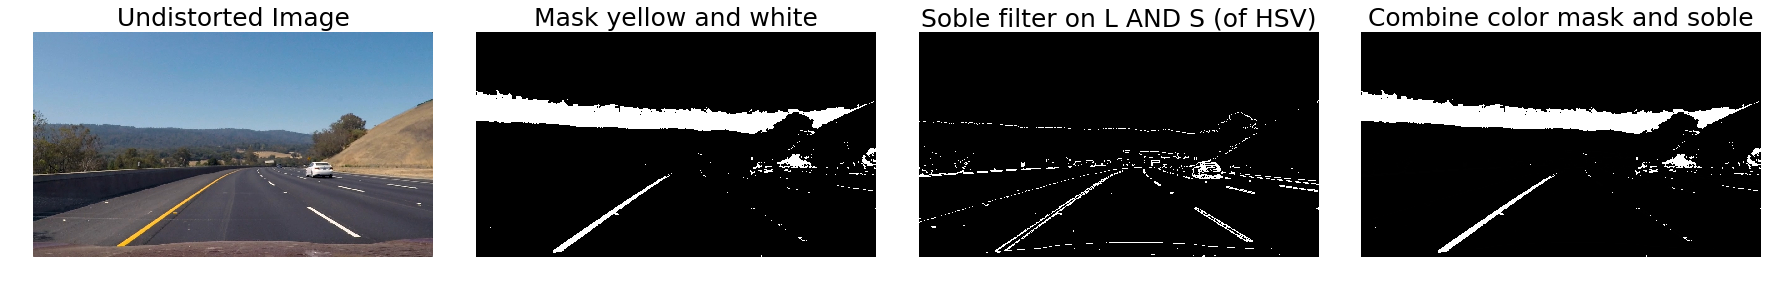

In [8]:
# Combine Color mask (white and yellow) and sobel filters (x,y) on HLS (l and s used)
# read in one test image 

def plot_image_with_color_mask_and_sobel_HLS(image):
    image_undist = cal_undistort(image, objpoints, imgpoints)

    mask_yellow_white = get_color_mask(image_undist)

    filter_hls_l_s = get_combined_sobel_mask(image_undist)

    image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 20))
    f.tight_layout()
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title('Undistorted Image', fontsize=25)
    ax2.imshow(mask_yellow_white, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Mask yellow and white', fontsize=25)
    ax3.imshow(filter_hls_l_s, cmap='gray')
    ax3.axis('off')
    ax3.set_title('Soble filter on L AND S (of HSV)', fontsize=25)
    ax4.imshow(image_filter_comb, cmap='gray')
    ax4.axis('off')
    ax4.set_title('Combine color mask and soble', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_image_with_color_mask_and_sobel_HLS(image)

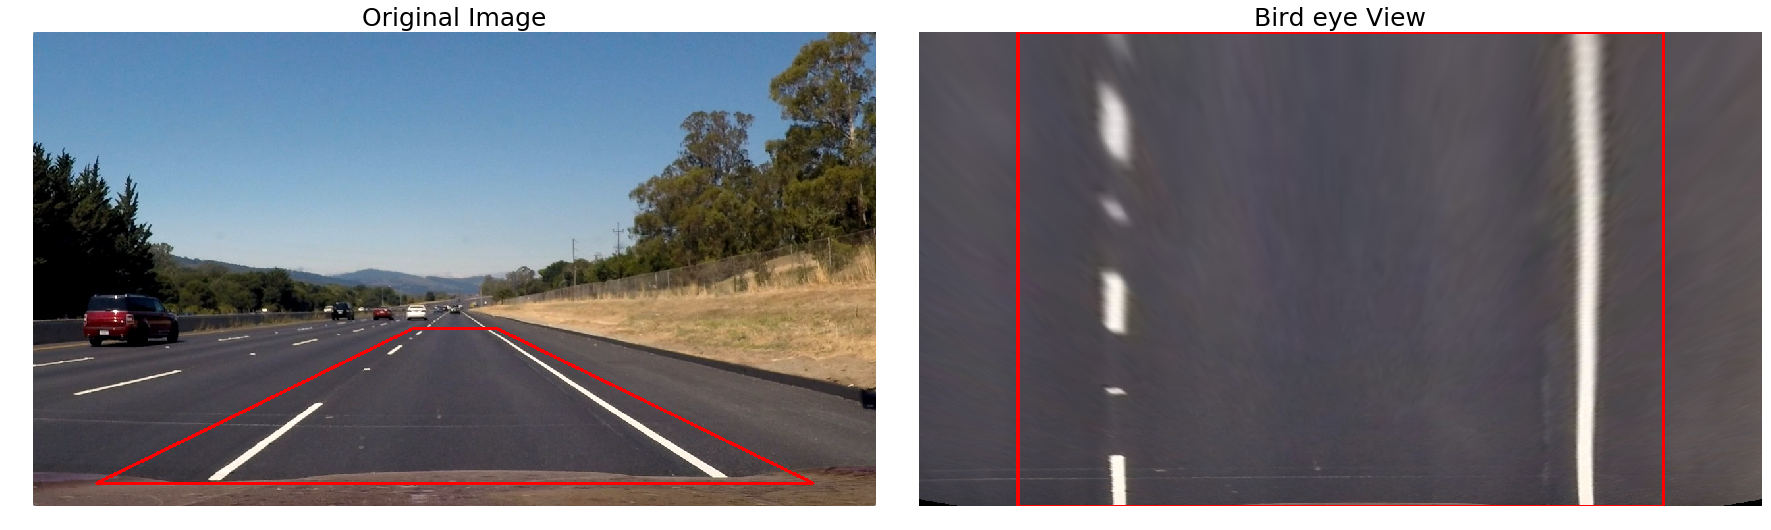

In [9]:
# Apply perspective transform to get Bird-Eye-View


def warp_image_int(image):
    # Get the size of the image
    image_size = np.shape(image)

    mid_y_points = int(np.uint(image_size[0] / 1.6))
    bottom_points = int(np.uint(image_size[0]) / 1.05)
    center_image = int(np.uint(image_size[1]/2))
    # TODO changenames
    ctl_window = int((center_image - (image_size[1] / 2) * 0.10))
    ctr_window = int((center_image + (image_size[1] / 2) * 0.10))
    cbl_window = int((center_image - (image_size[1] / 2) * 0.85))
    cbr_window = int((center_image + (image_size[1] / 2) * 0.85))

    points_src = [[cbl_window,bottom_points],[cbr_window,bottom_points],[ctr_window,mid_y_points],[ctl_window,mid_y_points]]
    points_dst = [[150,image_size[0]],[image_size[1]-150,image_size[0]],[image_size[1]-150,0],[150,0]]
    #points_dst = [[160,image_size[0]],[image_size[1]-160,image_size[0]],[image_size[1]-160,0],[160,0]]
    points_src_float = np.float32(points_src)
    points_dst_float = np.float32(points_dst)

    points_src_arr = np.array(points_src)
    points_dst_arr = np.array(points_dst)
    
    image_size = (image_size[1],image_size[0])
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(points_src_float, points_dst_float)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(points_dst_float, points_src_float)

    return warped, M, Minv, points_src_arr, points_dst_arr

def warp_image(image):
    
    warped, M, Minv, points_src_arr, points_dst_arr = warp_image_int(image)
    
    return warped, M, Minv

def plot_warp_image(image):
    
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    warped, M, Minv, points_src_arr, points_dst_arr = warp_image_int(image_undist)
    cv2.polylines(image, [points_src_arr], True, color = (255,0,0), thickness = 3)
    cv2.polylines(warped, [points_dst_arr], True, color = (255,0,0), thickness = 3)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)   
    ax1.axis('off')
    ax1.set_title('Original Image', fontsize=25)
    ax2.imshow(warped)
    ax2.axis('off')
    ax2.set_title('Bird eye View', fontsize=25)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
if print_debug == 1:
    # read in one test image 
    image = mpimg.imread('test_images/straight_lines2.jpg')

    plot_warp_image(image)

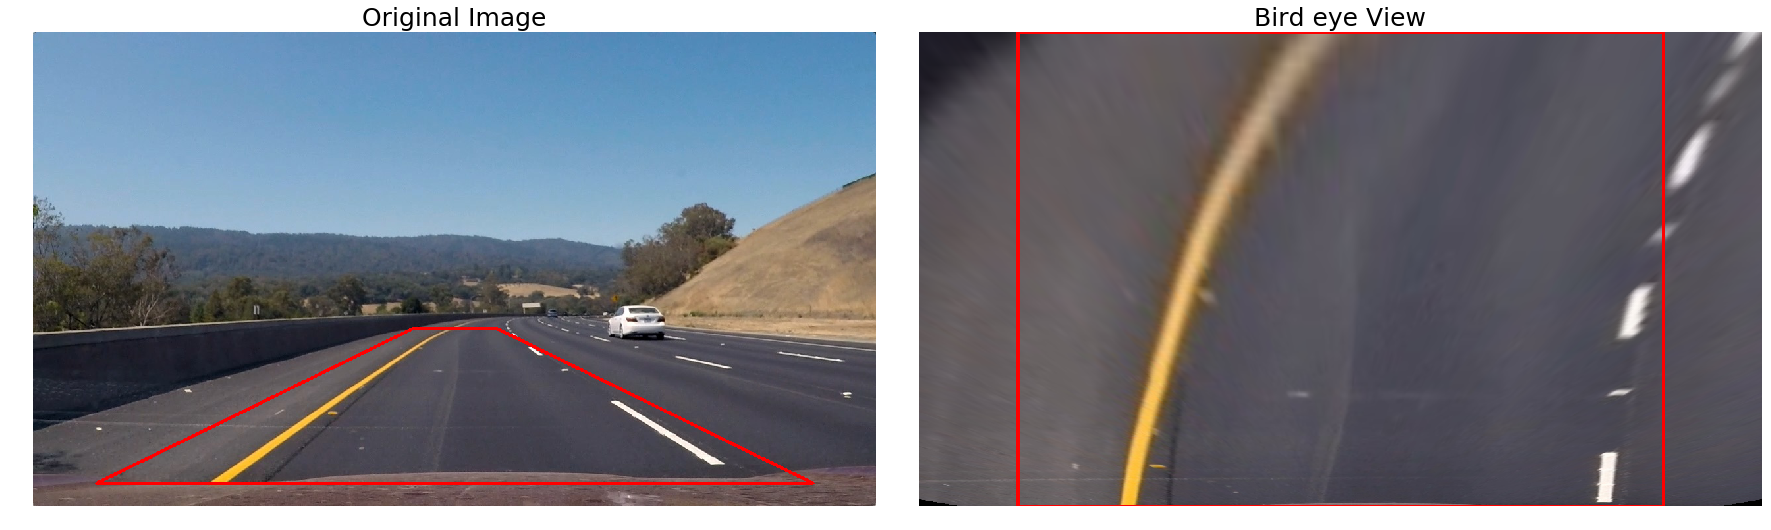

In [10]:
if print_debug == 1:
    # Apply perspective transform to get Bird-Eye-View
    # read in one test image 
    image = mpimg.imread('test_images/test3.jpg')

    plot_warp_image(image)

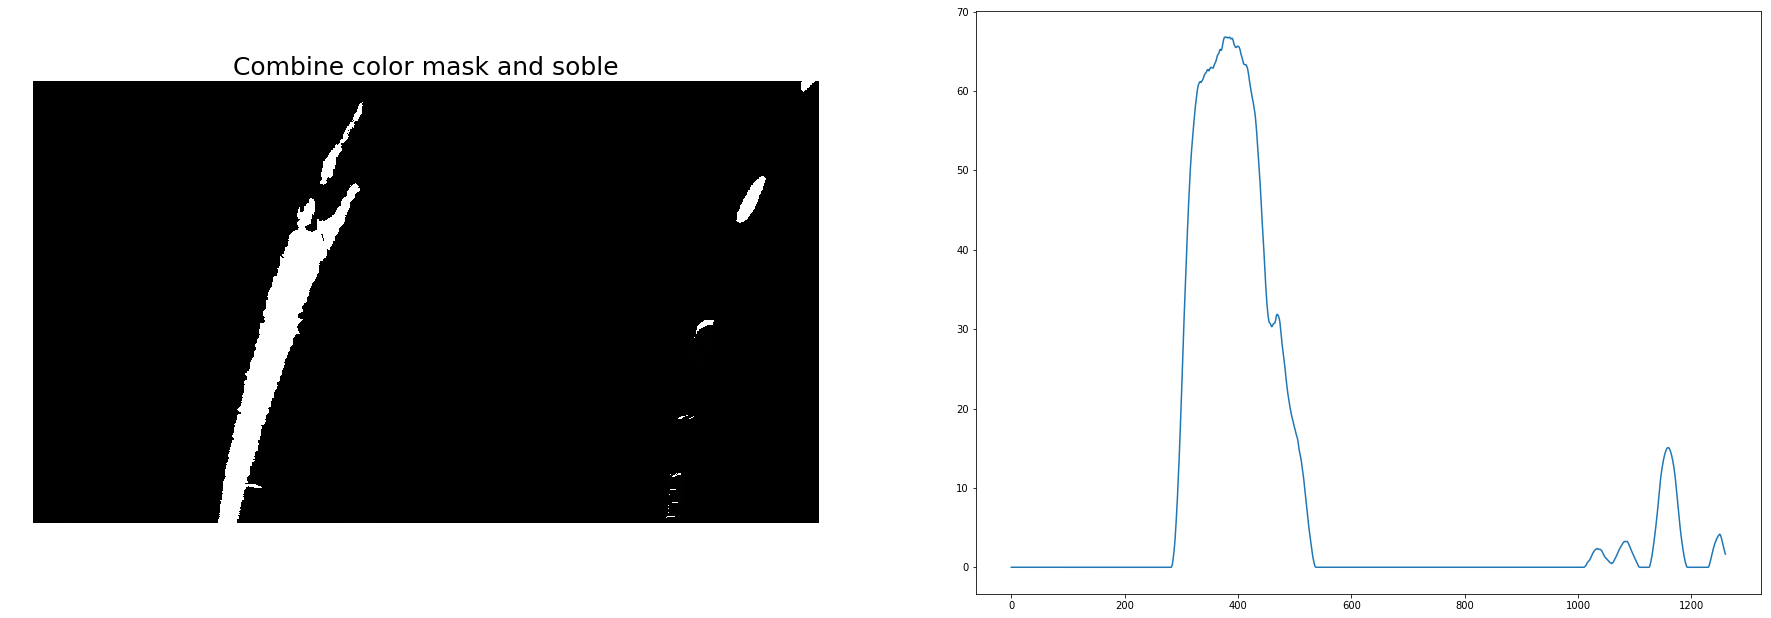

In [11]:
# Find lanes

def get_moving_average(data, N):
    mov_avg = np.convolve(data, np.ones((N,))/N, mode='valid')
    return mov_avg

def get_comb_filter(image):
    apply_gaussian = 0
    # undistort image
    image = cal_undistort(image, objpoints, imgpoints)
    
    if apply_gaussian == 1:
        image = apply_gaussian_blur(image, 5)
    
    warped, M_warp, M_inv_warp = warp_image(image)

    mask_yellow_white = get_color_mask(warped)
    
    filter_hls_l_s = get_combined_sobel_mask(warped)
    if apply_gaussian == 1:
        filter_hls_l_s = apply_gaussian_blur(filter_hls_l_s, 25)

    image_filter_comb = cv2.bitwise_or(filter_hls_l_s, mask_yellow_white) 
    
    mean_of_lane = np.mean(image_filter_comb, axis=0)
    mean_of_lane = get_moving_average(mean_of_lane, 20)
    
    return image_filter_comb, mean_of_lane

def plot_comb_filter(image):
    image_filter_comb, mean_of_lane = get_comb_filter(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image_filter_comb, cmap='gray')   
    ax1.axis('off')
    ax1.set_title('Combine color mask and soble', fontsize=25)
    ax2.plot(mean_of_lane)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')

    plot_comb_filter(image)

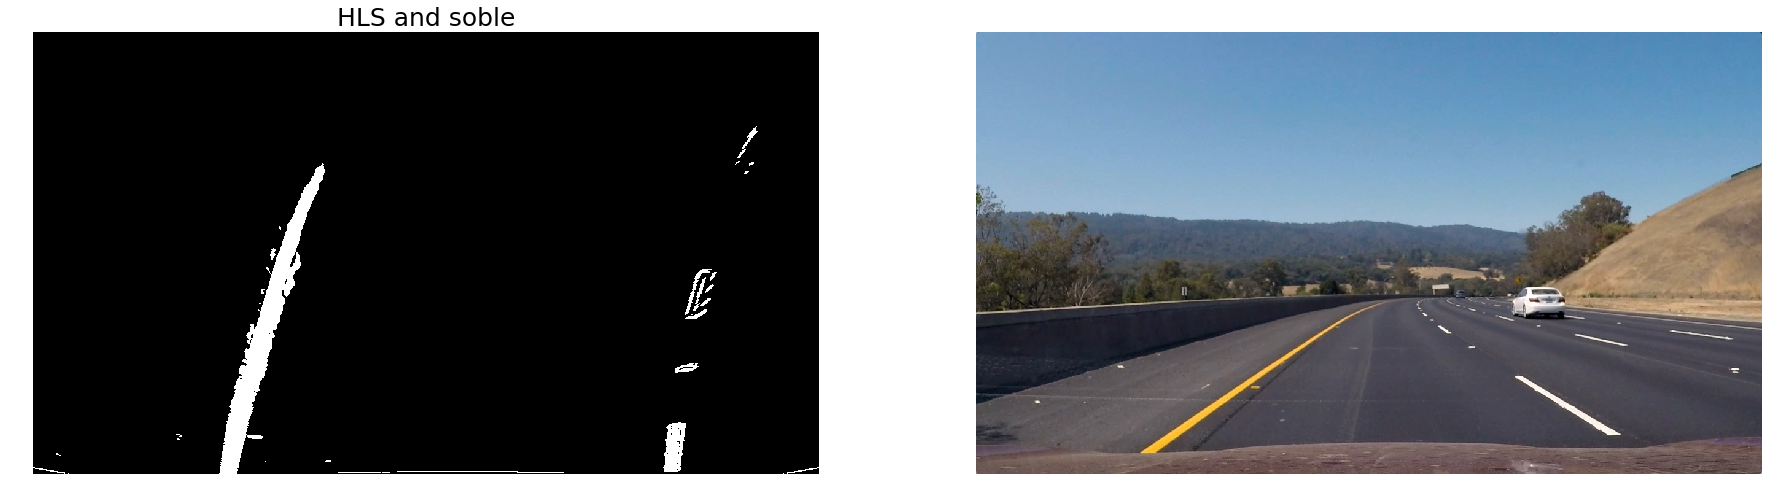

In [12]:
'''
This function applies a mask on H and S channels in HLS Color Space
Pixels with Saturation higher than 100 and hue than lower 100 are taken

'''
def get_hls_mask(image):
    
    tresh = 100
    # Convert to HLS Color Space
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # Filter H and S channel 
    image_hls_h = hls_image[:, :, 0]
    image_hls_s = hls_image[:, :, 2]
    
    # Generate mask
    mask = np.zeros_like(image_hls_h)
    mask[(image_hls_s > tresh) & (image_hls_h < tresh)] = 1
    
    return mask
'''
TODO This function applies a mask on H and S channels in HLS Color Space
Pixels with Saturation higher than 100 and hue than lower 100 are taken

'''
def get_mag_mask(image):
    #tresh = (10, 255)
    tresh = (35, 255)
    
    mag = mag_thresh(image, 3, tresh)
    # TODO try other value
    return mag

def get_comb_filter_final(image):
    # Copy image to not use the original
    
    # undistort image
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    # Wrap image
    warped, M_warp, M_inv_warp = warp_image(image_undist)
    
    # Get HLS filter mask
    mask_hls = get_hls_mask(warped)
    
    mask_mag = get_mag_mask(warped)
    
    final_mask = np.maximum(mask_mag, mask_hls)
   
    return final_mask

def plot_comb_filter_final(image):
    image_filter_comb = get_comb_filter_final(image)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(image_filter_comb, cmap='gray')   
    ax1.axis('off')
    ax1.set_title('HLS and soble', fontsize=25)
    ax2.imshow(image, cmap='gray')
    ax2.axis('off')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    plot_comb_filter_final(image)

/Users/daniel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


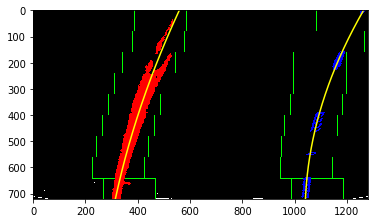

In [13]:
# Code from Lesson Finding the lines

import numpy as np
import cv2
import matplotlib.pyplot as plt

def find_first(binary_warped, do_print):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if do_print == 1:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, out_img
    
if print_debug == 1:
    # Combine Color mask (white and yellow) and sobel filters
    # read in one test image 
    #image = mpimg.imread('test_images/straight_lines2.jpg')
    image = mpimg.imread('test_images/test3.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    image_filter_comb, mean_of_lane = get_comb_filter(image)    
    left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_first(image_filter_comb, 1)


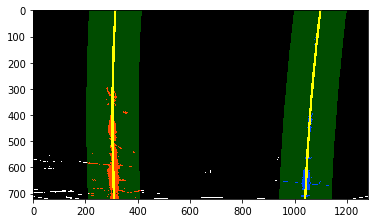

In [15]:
# Code from Lesson Finding the lines

margin = 100

def find_next(binary_warped, left_fit, right_fit, do_print):   
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # TODO important
    if (len(leftx) == 0 or len(lefty) == 0 or len(rightx) == 0 or len(righty) == 0):
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_first(image_filter_comb, 0)
        return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    add_yellow_lines = 1
    if add_yellow_lines == 1:
        # Add left/right polynom
        warp_zero_1 = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp_1 = np.dstack((warp_zero_1, warp_zero_1, warp_zero_1))

        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])

        cv2.polylines(result, np.int_([pts_left]), 0, color = (255,255, 0), thickness = 5)
        cv2.polylines(result, np.int_([pts_right]), 0, color = (255,255, 0), thickness = 5)

    return left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result

if print_debug == 1:
    #image = mpimg.imread('own_test_images/project/own_test3.jpg')
    image = mpimg.imread('test_images/straight_lines1.jpg')
    image = mpimg.imread('own_test_images/project/own_test1.jpg')
    #image = mpimg.imread('own_test_images/project/own_test0.jpg')

    image_filter_comb, mean_of_lane = get_comb_filter(image)

    left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result = find_next(image_filter_comb, left_fit, right_fit, 1)
    plt.imshow(result)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [16]:
# Code from lesson
# Calculate curvature pix

def calculate_curvature_pix(image_filter_comb, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    mean_curverad = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, mean_curverad

if print_debug == 1:
    left_curverad, right_curverad, mean_curverad = calculate_curvature_pix(image_filter_comb, left_fit, right_fit)

    print('Left line curvature (radius pix): ', left_curverad)
    print('Right line curvature (radius pix): ', right_curverad)
    print('Mean curvature (radius pix): ', mean_curverad)
    # Example values: 1926.74 1908.48

Left line curvature (radius pix):  7532.9087396
Right line curvature (radius pix):  8913.907042
Mean curvature (radius pix):  8223.4078908


In [17]:
# Code from lesson
# Calculate curvature real world

# TODO rework
def calculate_curvature_rw(binary_warped, left_fit_cr, right_fit_cr):
    # Define conversions in x and y from pixels space to meters
    y_calc_fac = 30 / 720 # meters per pixel in y dimension
    x_calc_fac = 3.7 / 700 # meters per pixel in x dimension
    
    image_size = np.shape(binary_warped)
    # Calculate where the lanes hit the bottom of the image
    left_bottom = left_fit[0] * image_size[0] ** 2 + left_fit[1] * image_size[0] + left_fit[2]
    right_bottom = right_fit[0] * image_size[0] ** 2 + right_fit[1] * image_size[0] + right_fit[2]

    # Next take the difference in pixels between left and right interceptor points
    road_width_in_pixels = right_bottom - left_bottom
    
    calculated_center = (left_bottom + right_bottom) / 2.0
    
    lane_deviation = (calculated_center - image_size[1] / 2.0) * x_calc_fac
    lane_deviation_round = round(lane_deviation, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty)
    
    # Calculate the radius of both lane lines
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * y_calc_fac + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * y_calc_fac + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit_cr[0])
    # Calculate the mean radius of both lines
    
    # Get mean of curvatures
    mean_curverad = np.mean([left_curverad, right_curverad]) 
    
    return left_curverad, right_curverad, mean_curverad, lane_deviation_round

if print_debug == 1:
    #left_curverad, right_curverad, lane_deviation = calculate_curvature_rw_old(image_filter_comb, left_fit, right_fit, leftx, rightx)

    left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
    print('Left line curvature (radius m): ', left_curverad)
    print('Right line curvature (radius m): ', right_curverad)
    print('Mean curvature (radius m): ', mean_curverad)
    print('Lane center (m): ', lane_deviation)
    # Example values: 1926.74 1908.48

Left line curvature (radius m):  2467.909374
Right line curvature (radius m):  2920.88478013
Mean curvature (radius m):  2694.39707707
Lane center (m):  0.19


/Users/daniel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


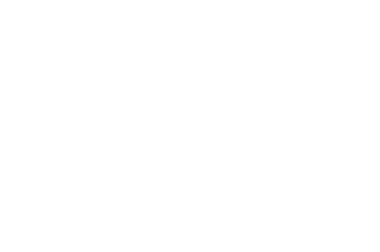

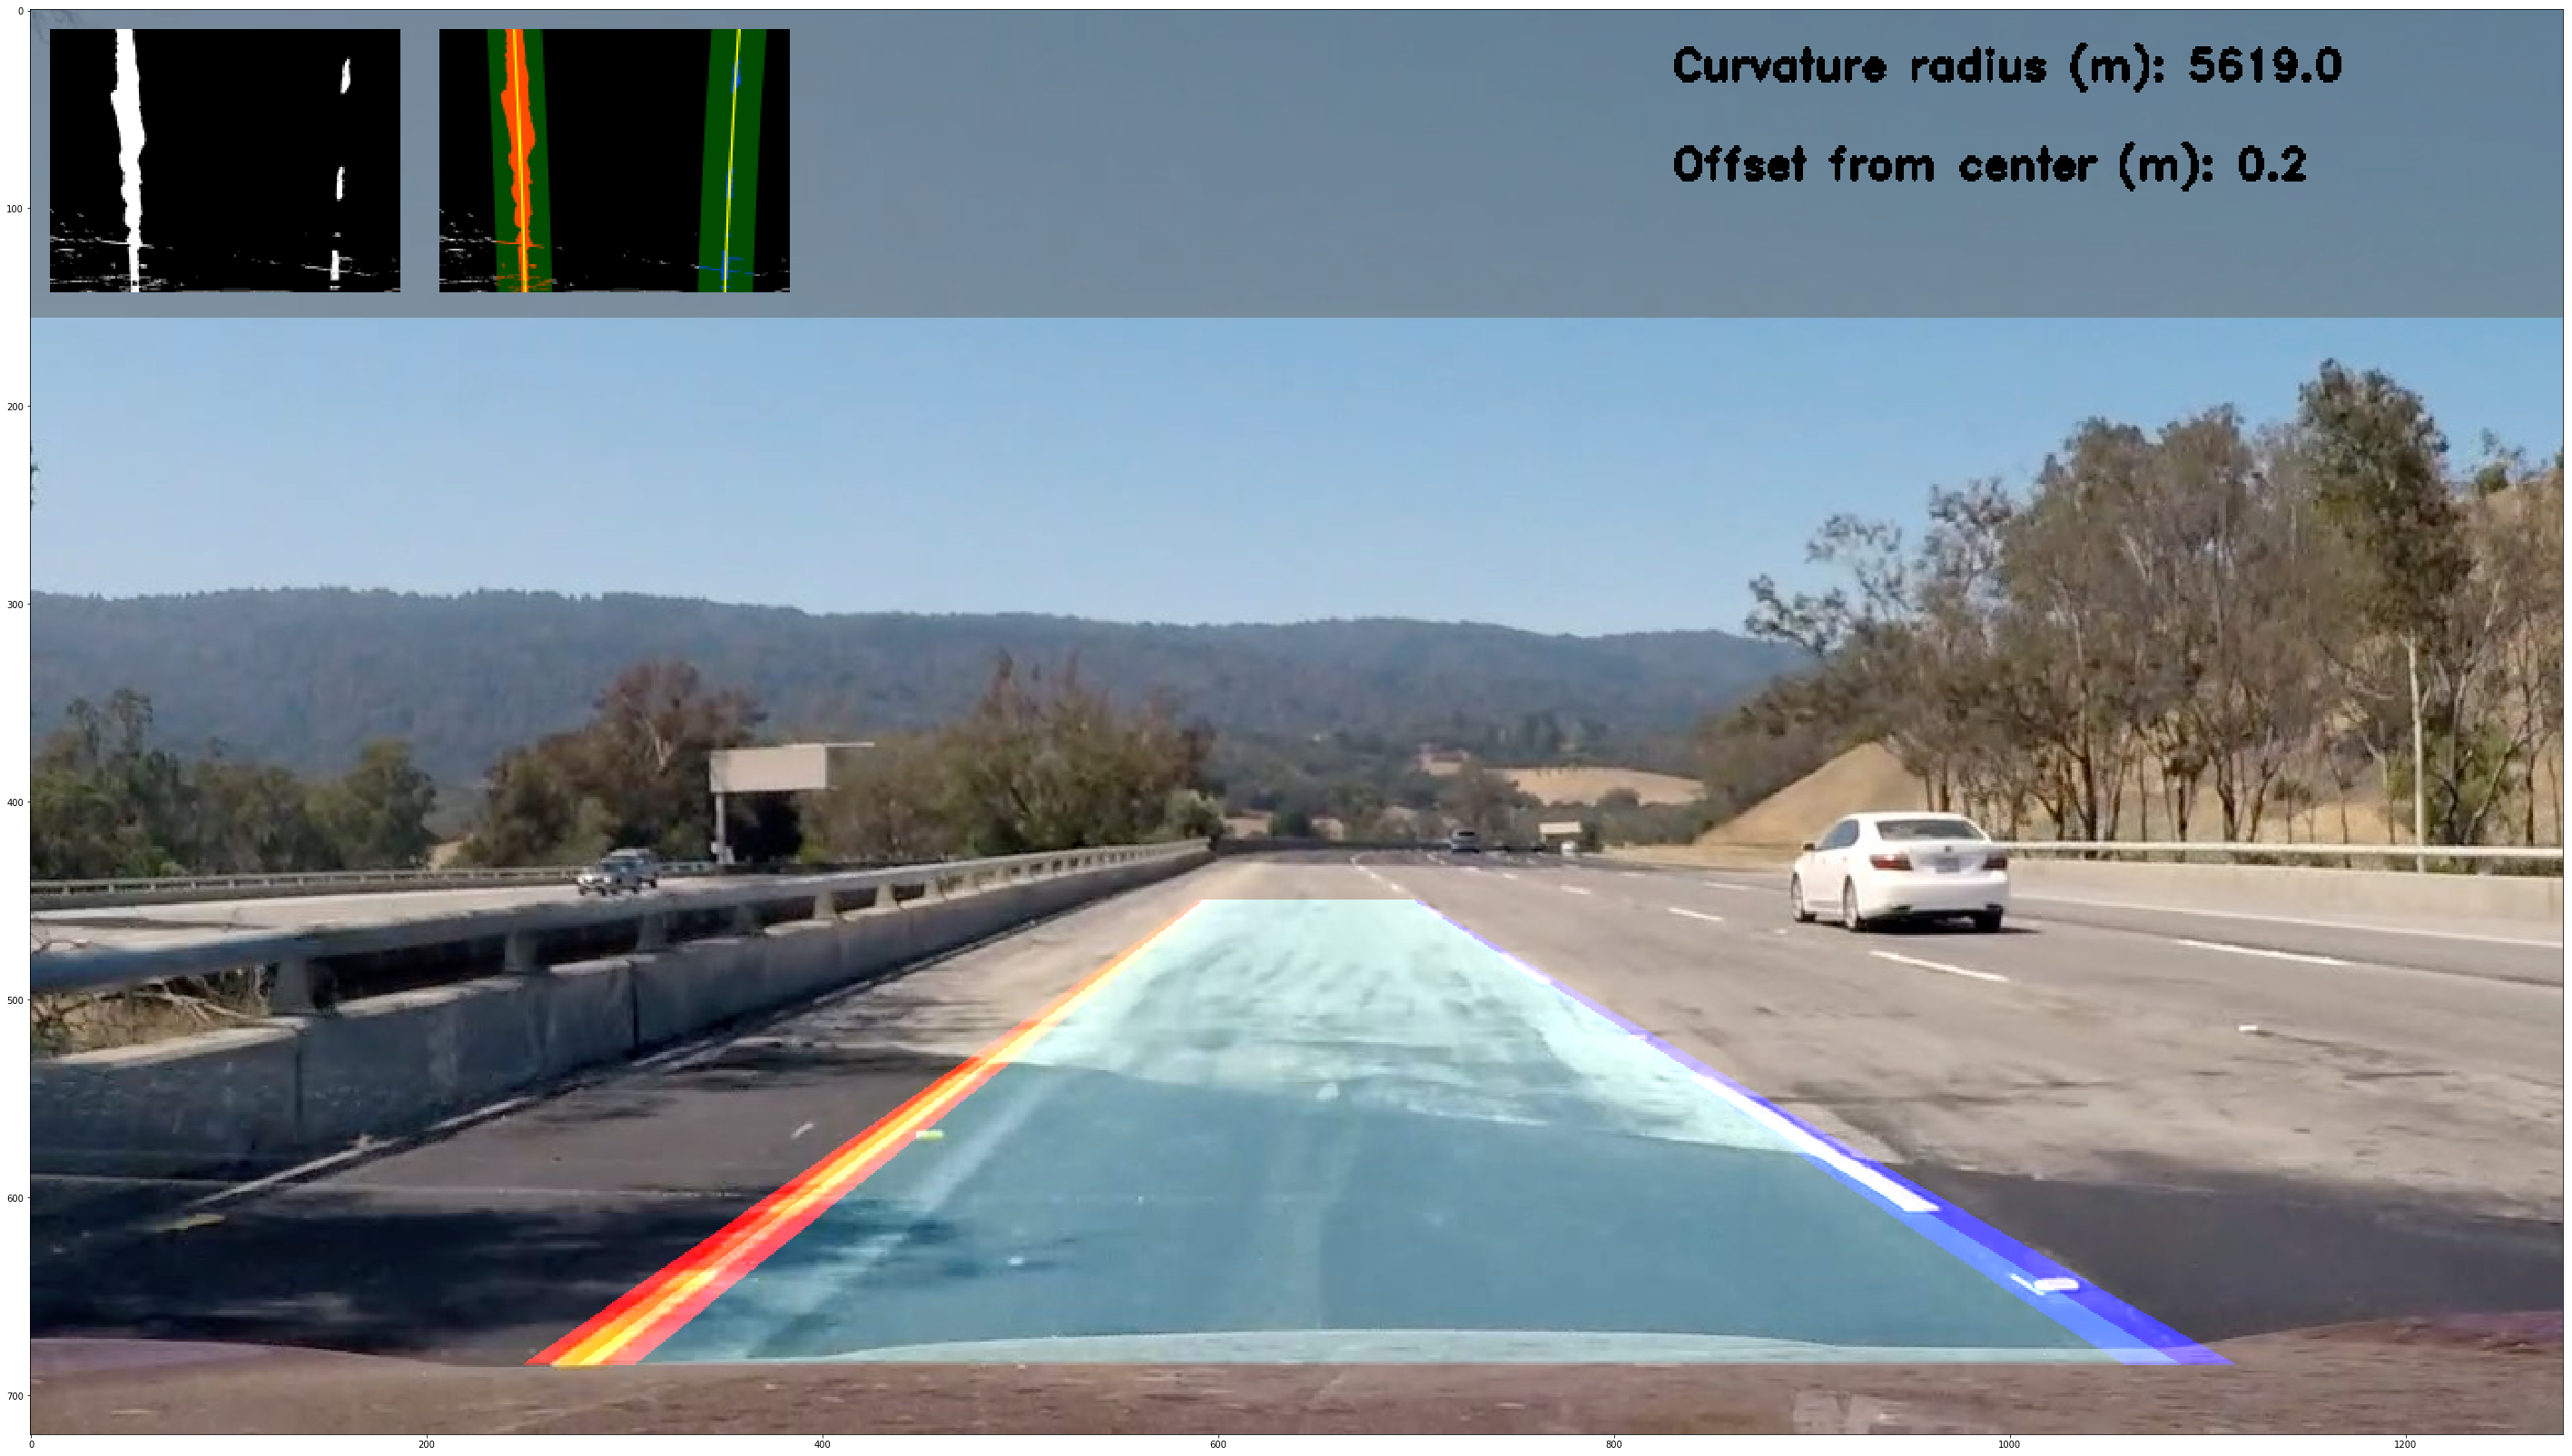

In [18]:
# Code from lesson

count = 0
left_fit = 0
right_fit = 0

def stack_arr(arr):
    # Stacks 1-channel array into 3-channel array to allow plotting
    return np.stack((arr, arr,arr), axis=2)

prev_mean_curverad = None
prev_left_fitx = None
prev_right_fitx = None
# Create an image to draw the lines on
def generate_processed_image(image):
    global count
    global left_fit, right_fit
    global prev_mean_curverad, prev_left_fitx, prev_right_fitx
    
    image_size = np.shape(image)
    
    # undistort image
    image_undist = cal_undistort(image, objpoints, imgpoints)
    
    # Wrap image
    dummy_1, dummy_2, M_inv_warp = warp_image(image_undist)
    
    # Weights for smother curves
    alpha_curv = 0.05
    alpha_fit = 0.2
    
    image_filter_comb = get_comb_filter_final(image)
    #image_filter_comb, test = get_comb_filter(image)
    
    warp_zero = np.zeros_like(image_filter_comb).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    warp_zero_1 = np.zeros_like(image_filter_comb).astype(np.uint8)
    color_warp_1 = np.dstack((warp_zero_1, warp_zero_1, warp_zero_1))
    
    if count == 0:
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_first(image_filter_comb, 0)
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_next(image_filter_comb, left_fit, right_fit, 0)
        count += 1
    else:
        print()
        left_fit, left_fitx, left_fit_cr, right_fit, right_fitx, right_fit_cr, result_filter = find_next(image_filter_comb, left_fit, right_fit, 0)    
     
    # TODO
    if prev_left_fitx is None:
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
    else:
        left_fitx = (1 - alpha_fit) * prev_left_fitx + alpha_fit * left_fitx
        right_fitx = (1 - alpha_fit) * prev_right_fitx + alpha_fit * right_fitx
        prev_left_fitx = left_fitx
        prev_right_fitx = right_fitx
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, image_filter_comb.shape[0]-1, image_filter_comb.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (66,217, 244))
    cv2.polylines(color_warp_1, np.int_([pts_left]), 0, color = (255,0, 0), thickness = 50)
    cv2.polylines(color_warp_1, np.int_([pts_right]), 0, color = (0,0, 255), thickness = 50)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv_warp, (image.shape[1], image.shape[0])) 
    newwarp_1 = cv2.warpPerspective(color_warp_1, M_inv_warp, (image.shape[1], image.shape[0]))
    #Combine the result with the original image
    result_1 = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result_1 = cv2.add(result_1,newwarp_1)
    
    left_curverad, right_curverad, mean_curverad, lane_deviation = calculate_curvature_rw(image_filter_comb, left_fit_cr, right_fit_cr)
    
    if prev_mean_curverad is None:
        prev_mean_curverad = mean_curverad
    else:
        prev_mean_curverad = (1 - alpha_curv) * prev_mean_curverad + alpha_curv * mean_curverad
        
    
    curv_mean = 'Curvature radius (m): ' + str(abs(round(mean_curverad, 0)))
    
    text_lane = 'Offset from center (m): ' + str(abs(lane_deviation))
    
    points_dst = [[0,image_size[0]-565],[image_size[1],image_size[0]-565],[image_size[1],0],[0,0]]
    points_dst_arr = np.array(points_dst)

    overlay = result_1.copy()
    
    alpha = 0.5
    cv2.fillPoly(overlay, [points_dst_arr], (100,100,100))
    cv2.addWeighted(overlay, alpha, result_1, 1 - alpha, 0, result_1)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(result_1,curv_mean,(image_size[1]-450,35), font, 0.7,(0,0,0),2)
    cv2.putText(result_1,text_lane,(image_size[1]-450,85), font, 0.7,(0,0,0),2)
    
    result_1[10:143, 10:187] = cv2.resize(stack_arr(255*image_filter_comb), (177,133), interpolation=cv2.INTER_AREA)
    result_1[10:143, 207:384] = cv2.resize(result_filter, (177,133), interpolation=cv2.INTER_AREA)
    
    return result_1

do_test = 1

if do_test == 1:
    #image_p = mpimg.imread('test_images/straight_lines1.jpg')
    image_p = mpimg.imread('own_test_images/project/own_test1.jpg')
    #image_p = mpimg.imread('own_test_images/project/own_test0.jpg')
    result_filter = generate_processed_image(image_p)

    count = 0

    plt.axis('off')
    plt.figure(figsize=(50,50))
    plt.imshow(result_filter)

In [19]:
# Test on video
import moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

output_file = 'processed_project_video.mp4'
input_file = 'project_video.mp4'

count = 0
clip = VideoFileClip(input_file)
out_clip = clip.fl_image(generate_processed_image) 
out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video processed_project_video.mp4
[MoviePy] Writing video processed_project_video.mp4


  0%|          | 1/1261 [00:01<21:19,  1.02s/it]

  0%|          | 2/1261 [00:02<21:12,  1.01s/it]

  0%|          | 3/1261 [00:03<21:13,  1.01s/it]

  0%|          | 4/1261 [00:04<21:10,  1.01s/it]

  0%|          | 5/1261 [00:05<21:09,  1.01s/it]

  0%|          | 6/1261 [00:06<21:02,  1.01s/it]

  1%|          | 7/1261 [00:07<21:09,  1.01s/it]

  1%|          | 8/1261 [00:08<21:24,  1.03s/it]

  1%|          | 9/1261 [00:09<21:20,  1.02s/it]

  1%|          | 10/1261 [00:10<21:10,  1.02s/it]

  1%|          | 11/1261 [00:11<21:18,  1.02s/it]

  1%|          | 12/1261 [00:12<21:10,  1.02s/it]

  1%|          | 13/1261 [00:13<21:04,  1.01s/it]

  1%|          | 14/1261 [00:14<20:58,  1.01s/it]

  1%|          | 15/1261 [00:15<21:05,  1.02s/it]

  1%|▏         | 16/1261 [00:16<21:05,  1.02s/it]

  1%|▏         | 17/1261 [00:17<21:00,  1.01s/it]

  1%|▏         | 18/1261 [00:18<21:02,  1.02s/it]

  2%|▏         | 19/1261 [00:19<21:12,  1.02s/it]

  2%|▏         | 20/1261 [00:20<21:09,  1.02s/it]

  2%|▏         | 21/1261 [00:21<21:01,  1.02s/it]

  2%|▏         | 22/1261 [00:22<20:53,  1.01s/it]

  2%|▏         | 23/1261 [00:23<20:47,  1.01s/it]

  2%|▏         | 24/1261 [00:24<20:42,  1.00s/it]

  2%|▏         | 25/1261 [00:25<20:38,  1.00s/it]

  2%|▏         | 26/1261 [00:26<20:41,  1.01s/it]

  2%|▏         | 27/1261 [00:27<21:08,  1.03s/it]

  2%|▏         | 28/1261 [00:28<21:22,  1.04s/it]

  2%|▏         | 29/1261 [00:29<21:21,  1.04s/it]

  2%|▏         | 30/1261 [00:30<21:14,  1.04s/it]

  2%|▏         | 31/1261 [00:31<21:25,  1.04s/it]

  3%|▎         | 32/1261 [00:32<21:23,  1.04s/it]

  3%|▎         | 33/1261 [00:33<21:12,  1.04s/it]

  3%|▎         | 34/1261 [00:34<20:58,  1.03s/it]

  3%|▎         | 35/1261 [00:35<20:50,  1.02s/it]

  3%|▎         | 36/1261 [00:36<20:40,  1.01s/it]

  3%|▎         | 37/1261 [00:37<20:33,  1.01s/it]

  3%|▎         | 38/1261 [00:38<20:27,  1.00s/it]

  3%|▎         | 39/1261 [00:39<20:23,  1.00s/it]

  3%|▎         | 40/1261 [00:40<20:21,  1.00s/it]

  3%|▎         | 41/1261 [00:41<20:18,  1.00it/s]

  3%|▎         | 42/1261 [00:42<20:15,  1.00it/s]

  3%|▎         | 43/1261 [00:43<20:16,  1.00it/s]

  3%|▎         | 44/1261 [00:44<20:15,  1.00it/s]

  4%|▎         | 45/1261 [00:45<20:16,  1.00s/it]

  4%|▎         | 46/1261 [00:46<20:29,  1.01s/it]

  4%|▎         | 47/1261 [00:47<20:39,  1.02s/it]

  4%|▍         | 48/1261 [00:48<20:51,  1.03s/it]

  4%|▍         | 49/1261 [00:49<20:51,  1.03s/it]

  4%|▍         | 50/1261 [00:50<20:43,  1.03s/it]

  4%|▍         | 51/1261 [00:51<20:31,  1.02s/it]

  4%|▍         | 52/1261 [00:52<20:39,  1.02s/it]

  4%|▍         | 53/1261 [00:53<20:59,  1.04s/it]

  4%|▍         | 54/1261 [00:54<20:49,  1.04s/it]

  4%|▍         | 55/1261 [00:55<20:34,  1.02s/it]

  4%|▍         | 56/1261 [00:56<20:24,  1.02s/it]

  5%|▍         | 57/1261 [00:57<20:17,  1.01s/it]

  5%|▍         | 58/1261 [00:58<20:13,  1.01s/it]

  5%|▍         | 59/1261 [00:59<20:09,  1.01s/it]

  5%|▍         | 60/1261 [01:00<20:06,  1.00s/it]

  5%|▍         | 61/1261 [01:01<20:03,  1.00s/it]

  5%|▍         | 62/1261 [01:02<20:01,  1.00s/it]

  5%|▍         | 63/1261 [01:03<19:59,  1.00s/it]

  5%|▌         | 64/1261 [01:04<19:58,  1.00s/it]

  5%|▌         | 65/1261 [01:06<20:11,  1.01s/it]

  5%|▌         | 66/1261 [01:07<20:14,  1.02s/it]

  5%|▌         | 67/1261 [01:08<20:08,  1.01s/it]

  5%|▌         | 68/1261 [01:09<20:02,  1.01s/it]

  5%|▌         | 69/1261 [01:10<19:56,  1.00s/it]

  6%|▌         | 70/1261 [01:11<19:52,  1.00s/it]

  6%|▌         | 71/1261 [01:12<19:51,  1.00s/it]

  6%|▌         | 72/1261 [01:13<19:48,  1.00it/s]

  6%|▌         | 73/1261 [01:14<19:47,  1.00it/s]

  6%|▌         | 74/1261 [01:15<19:44,  1.00it/s]

  6%|▌         | 75/1261 [01:16<19:43,  1.00it/s]

  6%|▌         | 76/1261 [01:17<19:44,  1.00it/s]

  6%|▌         | 77/1261 [01:18<19:42,  1.00it/s]

  6%|▌         | 78/1261 [01:19<19:41,  1.00it/s]

  6%|▋         | 79/1261 [01:20<19:56,  1.01s/it]

  6%|▋         | 80/1261 [01:21<20:13,  1.03s/it]

  6%|▋         | 81/1261 [01:22<20:26,  1.04s/it]

  7%|▋         | 82/1261 [01:23<20:30,  1.04s/it]

  7%|▋         | 83/1261 [01:24<20:27,  1.04s/it]

  7%|▋         | 84/1261 [01:25<20:30,  1.05s/it]

  7%|▋         | 85/1261 [01:26<20:12,  1.03s/it]

  7%|▋         | 86/1261 [01:27<20:06,  1.03s/it]

  7%|▋         | 87/1261 [01:28<20:07,  1.03s/it]

  7%|▋         | 88/1261 [01:29<19:59,  1.02s/it]

  7%|▋         | 89/1261 [01:30<19:49,  1.01s/it]

  7%|▋         | 90/1261 [01:31<19:41,  1.01s/it]

  7%|▋         | 91/1261 [01:32<19:54,  1.02s/it]

  7%|▋         | 92/1261 [01:33<20:02,  1.03s/it]

  7%|▋         | 93/1261 [01:34<19:53,  1.02s/it]

  7%|▋         | 94/1261 [01:35<19:53,  1.02s/it]

  8%|▊         | 95/1261 [01:36<19:45,  1.02s/it]

  8%|▊         | 96/1261 [01:37<19:44,  1.02s/it]

  8%|▊         | 97/1261 [01:38<19:41,  1.02s/it]

  8%|▊         | 98/1261 [01:39<19:40,  1.01s/it]

  8%|▊         | 99/1261 [01:40<19:47,  1.02s/it]

  8%|▊         | 100/1261 [01:41<19:57,  1.03s/it]

  8%|▊         | 101/1261 [01:42<19:55,  1.03s/it]

  8%|▊         | 102/1261 [01:43<19:47,  1.02s/it]

  8%|▊         | 103/1261 [01:44<19:42,  1.02s/it]

  8%|▊         | 104/1261 [01:45<19:38,  1.02s/it]

  8%|▊         | 105/1261 [01:46<19:30,  1.01s/it]

  8%|▊         | 106/1261 [01:47<19:25,  1.01s/it]

  8%|▊         | 107/1261 [01:48<19:19,  1.00s/it]

  9%|▊         | 108/1261 [01:49<19:15,  1.00s/it]

  9%|▊         | 109/1261 [01:50<19:12,  1.00s/it]

  9%|▊         | 110/1261 [01:51<19:09,  1.00it/s]

  9%|▉         | 111/1261 [01:52<19:07,  1.00it/s]

  9%|▉         | 112/1261 [01:53<19:07,  1.00it/s]

  9%|▉         | 113/1261 [01:54<19:13,  1.00s/it]

  9%|▉         | 114/1261 [01:55<19:26,  1.02s/it]

  9%|▉         | 115/1261 [01:56<19:36,  1.03s/it]

  9%|▉         | 116/1261 [01:57<19:29,  1.02s/it]

  9%|▉         | 117/1261 [01:58<19:29,  1.02s/it]

  9%|▉         | 118/1261 [01:59<19:34,  1.03s/it]

  9%|▉         | 119/1261 [02:00<19:28,  1.02s/it]

 10%|▉         | 120/1261 [02:01<19:35,  1.03s/it]

 10%|▉         | 121/1261 [02:02<19:42,  1.04s/it]

 10%|▉         | 122/1261 [02:04<19:49,  1.04s/it]

 10%|▉         | 123/1261 [02:05<19:47,  1.04s/it]

 10%|▉         | 124/1261 [02:06<19:49,  1.05s/it]

 10%|▉         | 125/1261 [02:07<19:53,  1.05s/it]

 10%|▉         | 126/1261 [02:08<19:50,  1.05s/it]

 10%|█         | 127/1261 [02:09<20:18,  1.07s/it]

 10%|█         | 128/1261 [02:10<20:34,  1.09s/it]

 10%|█         | 129/1261 [02:11<20:53,  1.11s/it]

 10%|█         | 130/1261 [02:12<20:54,  1.11s/it]

 10%|█         | 131/1261 [02:13<20:46,  1.10s/it]

 10%|█         | 132/1261 [02:14<20:50,  1.11s/it]

 11%|█         | 133/1261 [02:16<22:04,  1.17s/it]

 11%|█         | 134/1261 [02:17<21:37,  1.15s/it]

 11%|█         | 135/1261 [02:18<21:26,  1.14s/it]

 11%|█         | 136/1261 [02:19<21:00,  1.12s/it]

 11%|█         | 137/1261 [02:20<20:50,  1.11s/it]

 11%|█         | 138/1261 [02:21<20:34,  1.10s/it]

 11%|█         | 139/1261 [02:22<20:12,  1.08s/it]

 11%|█         | 140/1261 [02:23<19:54,  1.07s/it]

 11%|█         | 141/1261 [02:24<19:31,  1.05s/it]

 11%|█▏        | 142/1261 [02:25<19:16,  1.03s/it]

 11%|█▏        | 143/1261 [02:26<19:24,  1.04s/it]

 11%|█▏        | 144/1261 [02:27<19:15,  1.03s/it]

 11%|█▏        | 145/1261 [02:28<19:09,  1.03s/it]

 12%|█▏        | 146/1261 [02:29<19:04,  1.03s/it]

 12%|█▏        | 147/1261 [02:30<19:03,  1.03s/it]

 12%|█▏        | 148/1261 [02:32<19:00,  1.02s/it]

 12%|█▏        | 149/1261 [02:33<18:53,  1.02s/it]

 12%|█▏        | 150/1261 [02:34<18:44,  1.01s/it]

 12%|█▏        | 151/1261 [02:35<18:46,  1.01s/it]

 12%|█▏        | 152/1261 [02:36<18:43,  1.01s/it]

 12%|█▏        | 153/1261 [02:37<18:38,  1.01s/it]

 12%|█▏        | 154/1261 [02:38<18:34,  1.01s/it]

 12%|█▏        | 155/1261 [02:39<18:31,  1.00s/it]

 12%|█▏        | 156/1261 [02:40<18:28,  1.00s/it]

 12%|█▏        | 157/1261 [02:41<18:27,  1.00s/it]

 13%|█▎        | 158/1261 [02:42<18:33,  1.01s/it]

 13%|█▎        | 159/1261 [02:43<18:28,  1.01s/it]

 13%|█▎        | 160/1261 [02:44<18:28,  1.01s/it]

 13%|█▎        | 161/1261 [02:45<18:33,  1.01s/it]

 13%|█▎        | 162/1261 [02:46<18:28,  1.01s/it]

 13%|█▎        | 163/1261 [02:47<18:26,  1.01s/it]

 13%|█▎        | 164/1261 [02:48<18:33,  1.01s/it]

 13%|█▎        | 165/1261 [02:49<18:26,  1.01s/it]

 13%|█▎        | 166/1261 [02:50<18:26,  1.01s/it]

 13%|█▎        | 167/1261 [02:51<18:24,  1.01s/it]

 13%|█▎        | 168/1261 [02:52<18:27,  1.01s/it]

 13%|█▎        | 169/1261 [02:53<18:20,  1.01s/it]

 13%|█▎        | 170/1261 [02:54<18:17,  1.01s/it]

 14%|█▎        | 171/1261 [02:55<18:13,  1.00s/it]

 14%|█▎        | 172/1261 [02:56<18:12,  1.00s/it]

 14%|█▎        | 173/1261 [02:57<18:10,  1.00s/it]

 14%|█▍        | 174/1261 [02:58<18:23,  1.01s/it]

 14%|█▍        | 175/1261 [02:59<18:16,  1.01s/it]

 14%|█▍        | 176/1261 [03:00<18:10,  1.01s/it]

 14%|█▍        | 177/1261 [03:01<18:06,  1.00s/it]

 14%|█▍        | 178/1261 [03:02<18:03,  1.00s/it]

 14%|█▍        | 179/1261 [03:03<18:03,  1.00s/it]

 14%|█▍        | 180/1261 [03:04<18:07,  1.01s/it]

 14%|█▍        | 181/1261 [03:05<18:08,  1.01s/it]

 14%|█▍        | 182/1261 [03:06<18:08,  1.01s/it]

 15%|█▍        | 183/1261 [03:07<18:10,  1.01s/it]

 15%|█▍        | 184/1261 [03:08<18:13,  1.02s/it]

 15%|█▍        | 185/1261 [03:09<18:09,  1.01s/it]

 15%|█▍        | 186/1261 [03:10<18:18,  1.02s/it]

 15%|█▍        | 187/1261 [03:11<18:10,  1.01s/it]

 15%|█▍        | 188/1261 [03:12<18:15,  1.02s/it]

 15%|█▍        | 189/1261 [03:13<18:12,  1.02s/it]

 15%|█▌        | 190/1261 [03:14<18:04,  1.01s/it]

 15%|█▌        | 191/1261 [03:15<17:58,  1.01s/it]

 15%|█▌        | 192/1261 [03:16<17:54,  1.01s/it]

 15%|█▌        | 193/1261 [03:17<17:52,  1.00s/it]

 15%|█▌        | 194/1261 [03:18<17:49,  1.00s/it]

 15%|█▌        | 195/1261 [03:19<17:46,  1.00s/it]

 16%|█▌        | 196/1261 [03:20<17:42,  1.00it/s]

 16%|█▌        | 197/1261 [03:21<17:51,  1.01s/it]

 16%|█▌        | 198/1261 [03:22<17:47,  1.00s/it]

 16%|█▌        | 199/1261 [03:23<17:43,  1.00s/it]

 16%|█▌        | 200/1261 [03:24<17:41,  1.00s/it]

 16%|█▌        | 201/1261 [03:25<17:40,  1.00s/it]

 16%|█▌        | 202/1261 [03:26<17:39,  1.00s/it]

 16%|█▌        | 203/1261 [03:27<17:37,  1.00it/s]

 16%|█▌        | 204/1261 [03:28<17:36,  1.00it/s]

 16%|█▋        | 205/1261 [03:29<17:33,  1.00it/s]

 16%|█▋        | 206/1261 [03:30<17:32,  1.00it/s]

 16%|█▋        | 207/1261 [03:31<17:40,  1.01s/it]

 16%|█▋        | 208/1261 [03:32<17:36,  1.00s/it]

 17%|█▋        | 209/1261 [03:33<17:32,  1.00s/it]

 17%|█▋        | 210/1261 [03:34<17:30,  1.00it/s]

 17%|█▋        | 211/1261 [03:35<17:27,  1.00it/s]

 17%|█▋        | 212/1261 [03:36<17:26,  1.00it/s]

 17%|█▋        | 213/1261 [03:37<17:24,  1.00it/s]

 17%|█▋        | 214/1261 [03:38<17:23,  1.00it/s]

 17%|█▋        | 215/1261 [03:39<17:32,  1.01s/it]

 17%|█▋        | 216/1261 [03:40<17:27,  1.00s/it]

 17%|█▋        | 217/1261 [03:41<17:32,  1.01s/it]

 17%|█▋        | 218/1261 [03:42<17:45,  1.02s/it]

 17%|█▋        | 219/1261 [03:43<17:44,  1.02s/it]

 17%|█▋        | 220/1261 [03:44<17:44,  1.02s/it]

 18%|█▊        | 221/1261 [03:45<17:44,  1.02s/it]

 18%|█▊        | 222/1261 [03:46<17:48,  1.03s/it]

 18%|█▊        | 223/1261 [03:47<17:55,  1.04s/it]

 18%|█▊        | 224/1261 [03:48<18:00,  1.04s/it]

 18%|█▊        | 225/1261 [03:49<17:59,  1.04s/it]

 18%|█▊        | 226/1261 [03:50<17:58,  1.04s/it]

 18%|█▊        | 227/1261 [03:51<17:54,  1.04s/it]

 18%|█▊        | 228/1261 [03:52<17:52,  1.04s/it]

 18%|█▊        | 229/1261 [03:53<17:50,  1.04s/it]

 18%|█▊        | 230/1261 [03:54<17:47,  1.03s/it]

 18%|█▊        | 231/1261 [03:55<17:44,  1.03s/it]

 18%|█▊        | 232/1261 [03:56<17:41,  1.03s/it]

 18%|█▊        | 233/1261 [03:58<17:49,  1.04s/it]

 19%|█▊        | 234/1261 [03:59<17:53,  1.05s/it]

 19%|█▊        | 235/1261 [04:00<17:56,  1.05s/it]

 19%|█▊        | 236/1261 [04:01<17:50,  1.04s/it]

 19%|█▉        | 237/1261 [04:02<17:42,  1.04s/it]

 19%|█▉        | 238/1261 [04:03<17:30,  1.03s/it]

 19%|█▉        | 239/1261 [04:04<17:19,  1.02s/it]

 19%|█▉        | 240/1261 [04:05<17:21,  1.02s/it]

 19%|█▉        | 241/1261 [04:06<17:13,  1.01s/it]

 19%|█▉        | 242/1261 [04:07<17:08,  1.01s/it]

 19%|█▉        | 243/1261 [04:08<17:03,  1.00s/it]

 19%|█▉        | 244/1261 [04:09<17:00,  1.00s/it]

 19%|█▉        | 245/1261 [04:10<17:02,  1.01s/it]

 20%|█▉        | 246/1261 [04:11<17:16,  1.02s/it]

 20%|█▉        | 247/1261 [04:12<17:30,  1.04s/it]

 20%|█▉        | 248/1261 [04:13<17:18,  1.02s/it]

 20%|█▉        | 249/1261 [04:14<17:08,  1.02s/it]

 20%|█▉        | 250/1261 [04:15<17:04,  1.01s/it]

 20%|█▉        | 251/1261 [04:16<17:08,  1.02s/it]

 20%|█▉        | 252/1261 [04:17<17:05,  1.02s/it]

 20%|██        | 253/1261 [04:18<17:09,  1.02s/it]

 20%|██        | 254/1261 [04:19<17:24,  1.04s/it]

 20%|██        | 255/1261 [04:20<17:24,  1.04s/it]

 20%|██        | 256/1261 [04:21<17:19,  1.03s/it]

 20%|██        | 257/1261 [04:22<17:12,  1.03s/it]

 20%|██        | 258/1261 [04:23<17:12,  1.03s/it]

 21%|██        | 259/1261 [04:24<17:02,  1.02s/it]

 21%|██        | 260/1261 [04:25<17:04,  1.02s/it]

 21%|██        | 261/1261 [04:26<16:55,  1.02s/it]

 21%|██        | 262/1261 [04:27<16:49,  1.01s/it]

 21%|██        | 263/1261 [04:28<16:44,  1.01s/it]

 21%|██        | 264/1261 [04:29<16:40,  1.00s/it]

 21%|██        | 265/1261 [04:30<16:37,  1.00s/it]

 21%|██        | 266/1261 [04:31<16:34,  1.00it/s]

 21%|██        | 267/1261 [04:32<16:32,  1.00it/s]

 21%|██▏       | 268/1261 [04:33<16:41,  1.01s/it]

 21%|██▏       | 269/1261 [04:34<16:43,  1.01s/it]

 21%|██▏       | 270/1261 [04:35<16:54,  1.02s/it]

 21%|██▏       | 271/1261 [04:36<16:55,  1.03s/it]

 22%|██▏       | 272/1261 [04:37<16:59,  1.03s/it]

 22%|██▏       | 273/1261 [04:38<16:55,  1.03s/it]

 22%|██▏       | 274/1261 [04:39<16:46,  1.02s/it]

 22%|██▏       | 275/1261 [04:40<16:39,  1.01s/it]

 22%|██▏       | 276/1261 [04:41<16:33,  1.01s/it]

 22%|██▏       | 277/1261 [04:42<16:29,  1.01s/it]

 22%|██▏       | 278/1261 [04:43<16:25,  1.00s/it]

 22%|██▏       | 279/1261 [04:44<16:22,  1.00s/it]

 22%|██▏       | 280/1261 [04:45<16:21,  1.00s/it]

 22%|██▏       | 281/1261 [04:46<16:19,  1.00it/s]

 22%|██▏       | 282/1261 [04:47<16:18,  1.00it/s]

 22%|██▏       | 283/1261 [04:48<16:19,  1.00s/it]

 23%|██▎       | 284/1261 [04:49<16:27,  1.01s/it]

 23%|██▎       | 285/1261 [04:50<16:22,  1.01s/it]

 23%|██▎       | 286/1261 [04:51<16:19,  1.00s/it]

 23%|██▎       | 287/1261 [04:52<16:16,  1.00s/it]

 23%|██▎       | 288/1261 [04:53<16:13,  1.00s/it]

 23%|██▎       | 289/1261 [04:54<16:10,  1.00it/s]

 23%|██▎       | 290/1261 [04:55<16:09,  1.00it/s]

 23%|██▎       | 291/1261 [04:56<16:21,  1.01s/it]

 23%|██▎       | 292/1261 [04:57<16:16,  1.01s/it]

 23%|██▎       | 293/1261 [04:58<16:13,  1.01s/it]

 23%|██▎       | 294/1261 [04:59<16:19,  1.01s/it]

 23%|██▎       | 295/1261 [05:00<16:16,  1.01s/it]

 23%|██▎       | 296/1261 [05:01<16:11,  1.01s/it]

 24%|██▎       | 297/1261 [05:02<16:19,  1.02s/it]

 24%|██▎       | 298/1261 [05:03<16:30,  1.03s/it]

 24%|██▎       | 299/1261 [05:04<16:19,  1.02s/it]

 24%|██▍       | 300/1261 [05:05<16:12,  1.01s/it]

 24%|██▍       | 301/1261 [05:06<16:06,  1.01s/it]

 24%|██▍       | 302/1261 [05:07<16:03,  1.00s/it]

 24%|██▍       | 303/1261 [05:08<15:58,  1.00s/it]

 24%|██▍       | 304/1261 [05:09<15:56,  1.00it/s]

 24%|██▍       | 305/1261 [05:10<15:54,  1.00it/s]

 24%|██▍       | 306/1261 [05:11<15:52,  1.00it/s]

 24%|██▍       | 307/1261 [05:12<15:51,  1.00it/s]

 24%|██▍       | 308/1261 [05:13<15:50,  1.00it/s]

 25%|██▍       | 309/1261 [05:14<15:49,  1.00it/s]

 25%|██▍       | 310/1261 [05:15<15:49,  1.00it/s]

 25%|██▍       | 311/1261 [05:16<15:48,  1.00it/s]

 25%|██▍       | 312/1261 [05:17<15:47,  1.00it/s]

 25%|██▍       | 313/1261 [05:18<15:46,  1.00it/s]

 25%|██▍       | 314/1261 [05:19<15:45,  1.00it/s]

 25%|██▍       | 315/1261 [05:20<15:53,  1.01s/it]

 25%|██▌       | 316/1261 [05:21<15:52,  1.01s/it]

 25%|██▌       | 317/1261 [05:22<15:48,  1.00s/it]

 25%|██▌       | 318/1261 [05:23<15:45,  1.00s/it]

 25%|██▌       | 319/1261 [05:24<15:42,  1.00s/it]

 25%|██▌       | 320/1261 [05:25<15:48,  1.01s/it]

 25%|██▌       | 321/1261 [05:27<15:53,  1.01s/it]

 26%|██▌       | 322/1261 [05:28<15:59,  1.02s/it]

 26%|██▌       | 323/1261 [05:29<15:58,  1.02s/it]

 26%|██▌       | 324/1261 [05:30<15:56,  1.02s/it]

 26%|██▌       | 325/1261 [05:31<15:49,  1.01s/it]

 26%|██▌       | 326/1261 [05:32<15:43,  1.01s/it]

 26%|██▌       | 327/1261 [05:33<15:39,  1.01s/it]

 26%|██▌       | 328/1261 [05:34<15:51,  1.02s/it]

 26%|██▌       | 329/1261 [05:35<15:47,  1.02s/it]

 26%|██▌       | 330/1261 [05:36<15:50,  1.02s/it]

 26%|██▌       | 331/1261 [05:37<15:51,  1.02s/it]

 26%|██▋       | 332/1261 [05:38<15:51,  1.02s/it]

 26%|██▋       | 333/1261 [05:39<16:02,  1.04s/it]

 26%|██▋       | 334/1261 [05:40<16:03,  1.04s/it]

 27%|██▋       | 335/1261 [05:41<15:54,  1.03s/it]

 27%|██▋       | 336/1261 [05:42<15:44,  1.02s/it]

 27%|██▋       | 337/1261 [05:43<15:37,  1.02s/it]

 27%|██▋       | 338/1261 [05:44<15:33,  1.01s/it]

 27%|██▋       | 339/1261 [05:45<15:29,  1.01s/it]

 27%|██▋       | 340/1261 [05:46<15:26,  1.01s/it]

 27%|██▋       | 341/1261 [05:47<15:24,  1.00s/it]

 27%|██▋       | 342/1261 [05:48<15:22,  1.00s/it]

 27%|██▋       | 343/1261 [05:49<15:20,  1.00s/it]

 27%|██▋       | 344/1261 [05:50<15:17,  1.00s/it]

 27%|██▋       | 345/1261 [05:51<15:15,  1.00it/s]

 27%|██▋       | 346/1261 [05:52<15:15,  1.00s/it]

 28%|██▊       | 347/1261 [05:53<15:14,  1.00s/it]

 28%|██▊       | 348/1261 [05:54<15:12,  1.00it/s]

 28%|██▊       | 349/1261 [05:55<15:11,  1.00it/s]

 28%|██▊       | 350/1261 [05:56<15:10,  1.00it/s]

 28%|██▊       | 351/1261 [05:57<15:09,  1.00it/s]

 28%|██▊       | 352/1261 [05:58<15:09,  1.00s/it]

 28%|██▊       | 353/1261 [05:59<15:09,  1.00s/it]

 28%|██▊       | 354/1261 [06:00<15:07,  1.00s/it]

 28%|██▊       | 355/1261 [06:01<15:05,  1.00it/s]

 28%|██▊       | 356/1261 [06:02<15:04,  1.00it/s]

 28%|██▊       | 357/1261 [06:03<15:03,  1.00it/s]

 28%|██▊       | 358/1261 [06:04<15:02,  1.00it/s]

 28%|██▊       | 359/1261 [06:05<15:01,  1.00it/s]

 29%|██▊       | 360/1261 [06:06<15:01,  1.00s/it]

 29%|██▊       | 361/1261 [06:07<15:00,  1.00s/it]

 29%|██▊       | 362/1261 [06:08<14:59,  1.00s/it]

 29%|██▉       | 363/1261 [06:09<14:58,  1.00s/it]

 29%|██▉       | 364/1261 [06:10<14:57,  1.00s/it]

 29%|██▉       | 365/1261 [06:11<14:58,  1.00s/it]

 29%|██▉       | 366/1261 [06:12<15:05,  1.01s/it]

 29%|██▉       | 367/1261 [06:13<15:11,  1.02s/it]

 29%|██▉       | 368/1261 [06:14<15:18,  1.03s/it]

 29%|██▉       | 369/1261 [06:15<15:29,  1.04s/it]

 29%|██▉       | 370/1261 [06:16<15:46,  1.06s/it]

 29%|██▉       | 371/1261 [06:17<15:49,  1.07s/it]

 30%|██▉       | 372/1261 [06:18<15:50,  1.07s/it]

 30%|██▉       | 373/1261 [06:19<15:58,  1.08s/it]

 30%|██▉       | 374/1261 [06:21<16:27,  1.11s/it]

 30%|██▉       | 375/1261 [06:22<16:22,  1.11s/it]

 30%|██▉       | 376/1261 [06:23<16:13,  1.10s/it]

 30%|██▉       | 377/1261 [06:24<16:05,  1.09s/it]

 30%|██▉       | 378/1261 [06:25<15:49,  1.08s/it]

 30%|███       | 379/1261 [06:26<15:40,  1.07s/it]

 30%|███       | 380/1261 [06:27<15:30,  1.06s/it]

 30%|███       | 381/1261 [06:28<15:21,  1.05s/it]

 30%|███       | 382/1261 [06:29<15:13,  1.04s/it]

 30%|███       | 383/1261 [06:30<15:07,  1.03s/it]

 30%|███       | 384/1261 [06:31<15:03,  1.03s/it]

 31%|███       | 385/1261 [06:32<15:00,  1.03s/it]

 31%|███       | 386/1261 [06:33<14:58,  1.03s/it]

 31%|███       | 387/1261 [06:34<14:57,  1.03s/it]

 31%|███       | 388/1261 [06:35<14:55,  1.03s/it]

 31%|███       | 389/1261 [06:36<14:55,  1.03s/it]

 31%|███       | 390/1261 [06:37<14:54,  1.03s/it]

 31%|███       | 391/1261 [06:38<14:53,  1.03s/it]

 31%|███       | 392/1261 [06:39<14:52,  1.03s/it]

 31%|███       | 393/1261 [06:40<14:51,  1.03s/it]

 31%|███       | 394/1261 [06:41<14:49,  1.03s/it]

 31%|███▏      | 395/1261 [06:42<14:47,  1.03s/it]

 31%|███▏      | 396/1261 [06:43<14:46,  1.02s/it]

 31%|███▏      | 397/1261 [06:44<14:45,  1.03s/it]

 32%|███▏      | 398/1261 [06:45<14:45,  1.03s/it]

 32%|███▏      | 399/1261 [06:46<14:44,  1.03s/it]

 32%|███▏      | 400/1261 [06:47<14:44,  1.03s/it]

 32%|███▏      | 401/1261 [06:49<14:43,  1.03s/it]

 32%|███▏      | 402/1261 [06:50<14:42,  1.03s/it]

 32%|███▏      | 403/1261 [06:51<14:41,  1.03s/it]

 32%|███▏      | 404/1261 [06:52<14:39,  1.03s/it]

 32%|███▏      | 405/1261 [06:53<14:39,  1.03s/it]

 32%|███▏      | 406/1261 [06:54<14:38,  1.03s/it]

 32%|███▏      | 407/1261 [06:55<14:36,  1.03s/it]

 32%|███▏      | 408/1261 [06:56<14:35,  1.03s/it]

 32%|███▏      | 409/1261 [06:57<14:34,  1.03s/it]

 33%|███▎      | 410/1261 [06:58<14:33,  1.03s/it]

 33%|███▎      | 411/1261 [06:59<14:32,  1.03s/it]

 33%|███▎      | 412/1261 [07:00<14:30,  1.03s/it]

 33%|███▎      | 413/1261 [07:01<14:29,  1.03s/it]

 33%|███▎      | 414/1261 [07:02<14:28,  1.02s/it]

 33%|███▎      | 415/1261 [07:03<14:27,  1.02s/it]

 33%|███▎      | 416/1261 [07:04<14:26,  1.03s/it]

 33%|███▎      | 417/1261 [07:05<14:25,  1.03s/it]

 33%|███▎      | 418/1261 [07:06<14:24,  1.03s/it]

 33%|███▎      | 419/1261 [07:07<14:53,  1.06s/it]

 33%|███▎      | 420/1261 [07:08<14:47,  1.05s/it]

 33%|███▎      | 421/1261 [07:09<14:49,  1.06s/it]

 33%|███▎      | 422/1261 [07:10<14:55,  1.07s/it]

 34%|███▎      | 423/1261 [07:11<14:59,  1.07s/it]

 34%|███▎      | 424/1261 [07:12<15:01,  1.08s/it]

 34%|███▎      | 425/1261 [07:14<15:00,  1.08s/it]

 34%|███▍      | 426/1261 [07:15<15:00,  1.08s/it]

 34%|███▍      | 427/1261 [07:16<15:00,  1.08s/it]

 34%|███▍      | 428/1261 [07:17<14:58,  1.08s/it]

 34%|███▍      | 429/1261 [07:18<14:59,  1.08s/it]

 34%|███▍      | 430/1261 [07:19<14:56,  1.08s/it]

 34%|███▍      | 431/1261 [07:20<14:53,  1.08s/it]

 34%|███▍      | 432/1261 [07:21<14:50,  1.07s/it]

 34%|███▍      | 433/1261 [07:22<14:49,  1.07s/it]

 34%|███▍      | 434/1261 [07:23<14:48,  1.07s/it]

 34%|███▍      | 435/1261 [07:24<14:49,  1.08s/it]

 35%|███▍      | 436/1261 [07:25<14:49,  1.08s/it]

 35%|███▍      | 437/1261 [07:26<14:49,  1.08s/it]

 35%|███▍      | 438/1261 [07:28<14:48,  1.08s/it]

 35%|███▍      | 439/1261 [07:29<14:45,  1.08s/it]

 35%|███▍      | 440/1261 [07:30<14:45,  1.08s/it]

 35%|███▍      | 441/1261 [07:31<14:42,  1.08s/it]

 35%|███▌      | 442/1261 [07:32<14:43,  1.08s/it]

 35%|███▌      | 443/1261 [07:33<14:41,  1.08s/it]

 35%|███▌      | 444/1261 [07:34<14:40,  1.08s/it]

 35%|███▌      | 445/1261 [07:35<14:39,  1.08s/it]

 35%|███▌      | 446/1261 [07:36<14:39,  1.08s/it]

 35%|███▌      | 447/1261 [07:37<14:37,  1.08s/it]

 36%|███▌      | 448/1261 [07:38<14:34,  1.08s/it]

 36%|███▌      | 449/1261 [07:39<14:33,  1.08s/it]

 36%|███▌      | 450/1261 [07:40<14:33,  1.08s/it]

 36%|███▌      | 451/1261 [07:42<14:34,  1.08s/it]

 36%|███▌      | 452/1261 [07:43<14:35,  1.08s/it]

 36%|███▌      | 453/1261 [07:44<14:35,  1.08s/it]

 36%|███▌      | 454/1261 [07:45<14:36,  1.09s/it]

 36%|███▌      | 455/1261 [07:46<14:58,  1.12s/it]

 36%|███▌      | 456/1261 [07:47<14:57,  1.11s/it]

 36%|███▌      | 457/1261 [07:48<14:41,  1.10s/it]

 36%|███▋      | 458/1261 [07:49<14:29,  1.08s/it]

 36%|███▋      | 459/1261 [07:50<14:28,  1.08s/it]

 36%|███▋      | 460/1261 [07:51<14:27,  1.08s/it]

 37%|███▋      | 461/1261 [07:52<14:13,  1.07s/it]

 37%|███▋      | 462/1261 [07:53<13:56,  1.05s/it]

 37%|███▋      | 463/1261 [07:54<13:45,  1.04s/it]

 37%|███▋      | 464/1261 [07:55<13:37,  1.03s/it]

 37%|███▋      | 465/1261 [07:57<13:41,  1.03s/it]

 37%|███▋      | 466/1261 [07:58<13:32,  1.02s/it]

 37%|███▋      | 467/1261 [07:59<13:26,  1.02s/it]

 37%|███▋      | 468/1261 [07:59<13:20,  1.01s/it]

 37%|███▋      | 469/1261 [08:00<13:17,  1.01s/it]

 37%|███▋      | 470/1261 [08:01<13:15,  1.01s/it]

 37%|███▋      | 471/1261 [08:03<13:19,  1.01s/it]

 37%|███▋      | 472/1261 [08:04<13:15,  1.01s/it]

 38%|███▊      | 473/1261 [08:05<13:11,  1.00s/it]

 38%|███▊      | 474/1261 [08:06<13:08,  1.00s/it]

 38%|███▊      | 475/1261 [08:07<13:13,  1.01s/it]

 38%|███▊      | 476/1261 [08:08<13:20,  1.02s/it]

 38%|███▊      | 477/1261 [08:09<13:32,  1.04s/it]

 38%|███▊      | 478/1261 [08:10<13:28,  1.03s/it]

 38%|███▊      | 479/1261 [08:11<13:19,  1.02s/it]

 38%|███▊      | 480/1261 [08:12<13:12,  1.01s/it]

 38%|███▊      | 481/1261 [08:13<13:09,  1.01s/it]

 38%|███▊      | 482/1261 [08:14<13:05,  1.01s/it]

 38%|███▊      | 483/1261 [08:15<13:07,  1.01s/it]

 38%|███▊      | 484/1261 [08:16<13:12,  1.02s/it]

 38%|███▊      | 485/1261 [08:17<13:14,  1.02s/it]

 39%|███▊      | 486/1261 [08:18<13:15,  1.03s/it]

 39%|███▊      | 487/1261 [08:19<13:14,  1.03s/it]

 39%|███▊      | 488/1261 [08:20<13:22,  1.04s/it]

 39%|███▉      | 489/1261 [08:21<13:29,  1.05s/it]

 39%|███▉      | 490/1261 [08:22<13:23,  1.04s/it]

 39%|███▉      | 491/1261 [08:23<13:17,  1.04s/it]

 39%|███▉      | 492/1261 [08:24<13:07,  1.02s/it]

 39%|███▉      | 493/1261 [08:25<13:01,  1.02s/it]

 39%|███▉      | 494/1261 [08:26<12:56,  1.01s/it]

 39%|███▉      | 495/1261 [08:27<12:52,  1.01s/it]

 39%|███▉      | 496/1261 [08:28<12:48,  1.00s/it]

 39%|███▉      | 497/1261 [08:29<12:45,  1.00s/it]

 39%|███▉      | 498/1261 [08:30<12:43,  1.00s/it]

 40%|███▉      | 499/1261 [08:31<12:43,  1.00s/it]

 40%|███▉      | 500/1261 [08:32<12:50,  1.01s/it]

 40%|███▉      | 501/1261 [08:33<12:47,  1.01s/it]

 40%|███▉      | 502/1261 [08:34<12:50,  1.02s/it]

 40%|███▉      | 503/1261 [08:35<12:47,  1.01s/it]

 40%|███▉      | 504/1261 [08:36<12:43,  1.01s/it]

 40%|████      | 505/1261 [08:37<12:41,  1.01s/it]

 40%|████      | 506/1261 [08:38<12:50,  1.02s/it]

 40%|████      | 507/1261 [08:39<12:51,  1.02s/it]

 40%|████      | 508/1261 [08:40<13:00,  1.04s/it]

 40%|████      | 509/1261 [08:41<12:51,  1.03s/it]

 40%|████      | 510/1261 [08:42<12:45,  1.02s/it]

 41%|████      | 511/1261 [08:43<12:42,  1.02s/it]

 41%|████      | 512/1261 [08:44<12:40,  1.02s/it]

 41%|████      | 513/1261 [08:45<12:36,  1.01s/it]

 41%|████      | 514/1261 [08:46<12:40,  1.02s/it]

 41%|████      | 515/1261 [08:47<12:43,  1.02s/it]

 41%|████      | 516/1261 [08:48<12:37,  1.02s/it]

 41%|████      | 517/1261 [08:49<12:32,  1.01s/it]

 41%|████      | 518/1261 [08:50<12:28,  1.01s/it]

 41%|████      | 519/1261 [08:51<12:25,  1.01s/it]

 41%|████      | 520/1261 [08:52<12:23,  1.00s/it]

 41%|████▏     | 521/1261 [08:53<12:21,  1.00s/it]

 41%|████▏     | 522/1261 [08:54<12:19,  1.00s/it]

 41%|████▏     | 523/1261 [08:55<12:18,  1.00s/it]

 42%|████▏     | 524/1261 [08:56<12:15,  1.00it/s]

 42%|████▏     | 525/1261 [08:57<12:15,  1.00it/s]

 42%|████▏     | 526/1261 [08:58<12:23,  1.01s/it]

 42%|████▏     | 527/1261 [08:59<12:20,  1.01s/it]

 42%|████▏     | 528/1261 [09:00<12:17,  1.01s/it]

 42%|████▏     | 529/1261 [09:01<12:15,  1.00s/it]

 42%|████▏     | 530/1261 [09:02<12:14,  1.00s/it]

 42%|████▏     | 531/1261 [09:03<12:11,  1.00s/it]

 42%|████▏     | 532/1261 [09:04<12:10,  1.00s/it]

 42%|████▏     | 533/1261 [09:05<12:07,  1.00it/s]

 42%|████▏     | 534/1261 [09:06<12:06,  1.00it/s]

 42%|████▏     | 535/1261 [09:07<12:05,  1.00it/s]

 43%|████▎     | 536/1261 [09:08<12:05,  1.00s/it]

 43%|████▎     | 537/1261 [09:09<12:04,  1.00s/it]

 43%|████▎     | 538/1261 [09:10<12:03,  1.00s/it]

 43%|████▎     | 539/1261 [09:11<12:03,  1.00s/it]

 43%|████▎     | 540/1261 [09:12<12:02,  1.00s/it]

 43%|████▎     | 541/1261 [09:13<12:08,  1.01s/it]

 43%|████▎     | 542/1261 [09:14<12:11,  1.02s/it]

 43%|████▎     | 543/1261 [09:15<12:09,  1.02s/it]

 43%|████▎     | 544/1261 [09:16<12:07,  1.01s/it]

 43%|████▎     | 545/1261 [09:17<12:05,  1.01s/it]

 43%|████▎     | 546/1261 [09:18<12:04,  1.01s/it]

 43%|████▎     | 547/1261 [09:20<12:10,  1.02s/it]

 43%|████▎     | 548/1261 [09:21<12:06,  1.02s/it]

 44%|████▎     | 549/1261 [09:22<12:06,  1.02s/it]

 44%|████▎     | 550/1261 [09:23<12:09,  1.03s/it]

 44%|████▎     | 551/1261 [09:24<12:07,  1.02s/it]

 44%|████▍     | 552/1261 [09:25<12:04,  1.02s/it]

 44%|████▍     | 553/1261 [09:26<12:07,  1.03s/it]

 44%|████▍     | 554/1261 [09:27<12:08,  1.03s/it]

 44%|████▍     | 555/1261 [09:28<12:03,  1.02s/it]

 44%|████▍     | 556/1261 [09:29<11:58,  1.02s/it]

 44%|████▍     | 557/1261 [09:30<11:53,  1.01s/it]

 44%|████▍     | 558/1261 [09:31<11:50,  1.01s/it]

 44%|████▍     | 559/1261 [09:32<11:54,  1.02s/it]

 44%|████▍     | 560/1261 [09:33<12:04,  1.03s/it]

 44%|████▍     | 561/1261 [09:34<11:59,  1.03s/it]

 45%|████▍     | 562/1261 [09:35<11:53,  1.02s/it]

 45%|████▍     | 563/1261 [09:36<11:48,  1.02s/it]

 45%|████▍     | 564/1261 [09:37<11:43,  1.01s/it]

 45%|████▍     | 565/1261 [09:38<11:41,  1.01s/it]

 45%|████▍     | 566/1261 [09:39<11:37,  1.00s/it]

 45%|████▍     | 567/1261 [09:40<11:35,  1.00s/it]

 45%|████▌     | 568/1261 [09:41<11:33,  1.00s/it]

 45%|████▌     | 569/1261 [09:42<11:31,  1.00it/s]

 45%|████▌     | 570/1261 [09:43<11:30,  1.00it/s]

 45%|████▌     | 571/1261 [09:44<11:28,  1.00it/s]

 45%|████▌     | 572/1261 [09:45<11:27,  1.00it/s]

 45%|████▌     | 573/1261 [09:46<11:26,  1.00it/s]

 46%|████▌     | 574/1261 [09:47<11:26,  1.00it/s]

 46%|████▌     | 575/1261 [09:48<11:25,  1.00it/s]

 46%|████▌     | 576/1261 [09:49<11:23,  1.00it/s]

 46%|████▌     | 577/1261 [09:50<11:22,  1.00it/s]

 46%|████▌     | 578/1261 [09:51<11:21,  1.00it/s]

 46%|████▌     | 579/1261 [09:52<11:20,  1.00it/s]

 46%|████▌     | 580/1261 [09:53<11:20,  1.00it/s]

 46%|████▌     | 581/1261 [09:54<11:23,  1.00s/it]

 46%|████▌     | 582/1261 [09:55<11:23,  1.01s/it]

 46%|████▌     | 583/1261 [09:56<11:26,  1.01s/it]

 46%|████▋     | 584/1261 [09:57<11:34,  1.03s/it]

 46%|████▋     | 585/1261 [09:58<11:28,  1.02s/it]

 46%|████▋     | 586/1261 [09:59<11:24,  1.01s/it]

 47%|████▋     | 587/1261 [10:00<11:19,  1.01s/it]

 47%|████▋     | 588/1261 [10:01<11:15,  1.00s/it]

 47%|████▋     | 589/1261 [10:02<11:13,  1.00s/it]

 47%|████▋     | 590/1261 [10:03<11:11,  1.00s/it]

 47%|████▋     | 591/1261 [10:04<11:08,  1.00it/s]

 47%|████▋     | 592/1261 [10:05<11:06,  1.00it/s]

 47%|████▋     | 593/1261 [10:06<11:05,  1.00it/s]

 47%|████▋     | 594/1261 [10:07<11:03,  1.00it/s]

 47%|████▋     | 595/1261 [10:08<11:02,  1.01it/s]

 47%|████▋     | 596/1261 [10:09<11:08,  1.00s/it]

 47%|████▋     | 597/1261 [10:10<11:21,  1.03s/it]

 47%|████▋     | 598/1261 [10:11<11:18,  1.02s/it]

 48%|████▊     | 599/1261 [10:12<11:14,  1.02s/it]

 48%|████▊     | 600/1261 [10:13<11:13,  1.02s/it]

 48%|████▊     | 601/1261 [10:14<11:17,  1.03s/it]

 48%|████▊     | 602/1261 [10:15<11:27,  1.04s/it]

 48%|████▊     | 603/1261 [10:16<11:35,  1.06s/it]

 48%|████▊     | 604/1261 [10:17<11:37,  1.06s/it]

 48%|████▊     | 605/1261 [10:18<11:39,  1.07s/it]

 48%|████▊     | 606/1261 [10:19<11:39,  1.07s/it]

 48%|████▊     | 607/1261 [10:21<11:37,  1.07s/it]

 48%|████▊     | 608/1261 [10:22<11:33,  1.06s/it]

 48%|████▊     | 609/1261 [10:23<11:32,  1.06s/it]

 48%|████▊     | 610/1261 [10:24<11:27,  1.06s/it]

 48%|████▊     | 611/1261 [10:25<11:29,  1.06s/it]

 49%|████▊     | 612/1261 [10:26<11:24,  1.06s/it]

 49%|████▊     | 613/1261 [10:27<11:25,  1.06s/it]

 49%|████▊     | 614/1261 [10:28<11:23,  1.06s/it]

 49%|████▉     | 615/1261 [10:29<11:18,  1.05s/it]

 49%|████▉     | 616/1261 [10:30<11:36,  1.08s/it]

 49%|████▉     | 617/1261 [10:31<11:30,  1.07s/it]

 49%|████▉     | 618/1261 [10:32<11:21,  1.06s/it]

 49%|████▉     | 619/1261 [10:33<11:11,  1.05s/it]

 49%|████▉     | 620/1261 [10:34<11:11,  1.05s/it]

 49%|████▉     | 621/1261 [10:35<11:12,  1.05s/it]

 49%|████▉     | 622/1261 [10:36<10:59,  1.03s/it]

 49%|████▉     | 623/1261 [10:37<10:51,  1.02s/it]

 49%|████▉     | 624/1261 [10:38<10:44,  1.01s/it]

 50%|████▉     | 625/1261 [10:39<10:39,  1.01s/it]

 50%|████▉     | 626/1261 [10:40<10:38,  1.01s/it]

 50%|████▉     | 627/1261 [10:41<10:38,  1.01s/it]

 50%|████▉     | 628/1261 [10:42<10:39,  1.01s/it]

 50%|████▉     | 629/1261 [10:43<10:39,  1.01s/it]

 50%|████▉     | 630/1261 [10:44<10:42,  1.02s/it]

 50%|█████     | 631/1261 [10:45<10:40,  1.02s/it]

 50%|█████     | 632/1261 [10:46<10:46,  1.03s/it]

 50%|█████     | 633/1261 [10:48<10:49,  1.03s/it]

 50%|█████     | 634/1261 [10:49<10:51,  1.04s/it]

 50%|█████     | 635/1261 [10:50<10:53,  1.04s/it]

 50%|█████     | 636/1261 [10:51<10:50,  1.04s/it]

 51%|█████     | 637/1261 [10:52<10:49,  1.04s/it]

 51%|█████     | 638/1261 [10:53<10:41,  1.03s/it]

 51%|█████     | 639/1261 [10:54<10:32,  1.02s/it]

 51%|█████     | 640/1261 [10:55<10:26,  1.01s/it]

 51%|█████     | 641/1261 [10:56<10:22,  1.00s/it]

 51%|█████     | 642/1261 [10:57<10:19,  1.00s/it]

 51%|█████     | 643/1261 [10:58<10:16,  1.00it/s]

 51%|█████     | 644/1261 [10:59<10:14,  1.00it/s]

 51%|█████     | 645/1261 [11:00<10:12,  1.01it/s]

 51%|█████     | 646/1261 [11:01<10:11,  1.01it/s]

 51%|█████▏    | 647/1261 [11:02<10:09,  1.01it/s]

 51%|█████▏    | 648/1261 [11:03<10:18,  1.01s/it]

 51%|█████▏    | 649/1261 [11:04<10:24,  1.02s/it]

 52%|█████▏    | 650/1261 [11:05<10:26,  1.03s/it]

 52%|█████▏    | 651/1261 [11:06<10:22,  1.02s/it]

 52%|█████▏    | 652/1261 [11:07<10:16,  1.01s/it]

 52%|█████▏    | 653/1261 [11:08<10:12,  1.01s/it]

 52%|█████▏    | 654/1261 [11:09<10:08,  1.00s/it]

 52%|█████▏    | 655/1261 [11:10<10:05,  1.00it/s]

 52%|█████▏    | 656/1261 [11:11<10:03,  1.00it/s]

 52%|█████▏    | 657/1261 [11:12<10:01,  1.00it/s]

 52%|█████▏    | 658/1261 [11:13<10:00,  1.00it/s]

 52%|█████▏    | 659/1261 [11:14<09:58,  1.01it/s]

 52%|█████▏    | 660/1261 [11:15<09:56,  1.01it/s]

 52%|█████▏    | 661/1261 [11:16<10:01,  1.00s/it]

 52%|█████▏    | 662/1261 [11:17<10:03,  1.01s/it]

 53%|█████▎    | 663/1261 [11:18<10:03,  1.01s/it]

 53%|█████▎    | 664/1261 [11:19<10:06,  1.02s/it]

 53%|█████▎    | 665/1261 [11:20<10:03,  1.01s/it]

 53%|█████▎    | 666/1261 [11:21<09:59,  1.01s/it]

 53%|█████▎    | 667/1261 [11:22<09:54,  1.00s/it]

 53%|█████▎    | 668/1261 [11:23<09:53,  1.00s/it]

 53%|█████▎    | 669/1261 [11:24<09:55,  1.01s/it]

 53%|█████▎    | 670/1261 [11:25<10:01,  1.02s/it]

 53%|█████▎    | 671/1261 [11:26<09:58,  1.02s/it]

 53%|█████▎    | 672/1261 [11:27<09:54,  1.01s/it]

 53%|█████▎    | 673/1261 [11:28<09:51,  1.01s/it]

 53%|█████▎    | 674/1261 [11:29<09:53,  1.01s/it]

 54%|█████▎    | 675/1261 [11:30<09:53,  1.01s/it]

 54%|█████▎    | 676/1261 [11:31<09:50,  1.01s/it]

 54%|█████▎    | 677/1261 [11:32<09:48,  1.01s/it]

 54%|█████▍    | 678/1261 [11:33<09:46,  1.01s/it]

 54%|█████▍    | 679/1261 [11:34<09:47,  1.01s/it]

 54%|█████▍    | 680/1261 [11:35<09:45,  1.01s/it]

 54%|█████▍    | 681/1261 [11:36<09:45,  1.01s/it]

 54%|█████▍    | 682/1261 [11:37<09:43,  1.01s/it]

 54%|█████▍    | 683/1261 [11:38<09:48,  1.02s/it]

 54%|█████▍    | 684/1261 [11:39<09:50,  1.02s/it]

 54%|█████▍    | 685/1261 [11:40<09:53,  1.03s/it]

 54%|█████▍    | 686/1261 [11:41<09:51,  1.03s/it]

 54%|█████▍    | 687/1261 [11:42<09:52,  1.03s/it]

 55%|█████▍    | 688/1261 [11:43<09:45,  1.02s/it]

 55%|█████▍    | 689/1261 [11:44<09:40,  1.01s/it]

 55%|█████▍    | 690/1261 [11:45<09:36,  1.01s/it]

 55%|█████▍    | 691/1261 [11:46<09:33,  1.01s/it]

 55%|█████▍    | 692/1261 [11:47<09:31,  1.00s/it]

 55%|█████▍    | 693/1261 [11:48<09:29,  1.00s/it]

 55%|█████▌    | 694/1261 [11:49<09:28,  1.00s/it]

 55%|█████▌    | 695/1261 [11:50<09:26,  1.00s/it]

 55%|█████▌    | 696/1261 [11:51<09:25,  1.00s/it]

 55%|█████▌    | 697/1261 [11:52<09:24,  1.00s/it]

 55%|█████▌    | 698/1261 [11:53<09:23,  1.00s/it]

 55%|█████▌    | 699/1261 [11:54<09:20,  1.00it/s]

 56%|█████▌    | 700/1261 [11:55<09:20,  1.00it/s]

 56%|█████▌    | 701/1261 [11:56<09:18,  1.00it/s]

 56%|█████▌    | 702/1261 [11:57<09:18,  1.00it/s]

 56%|█████▌    | 703/1261 [11:58<09:18,  1.00s/it]

 56%|█████▌    | 704/1261 [11:59<09:18,  1.00s/it]

 56%|█████▌    | 705/1261 [12:00<09:16,  1.00s/it]

 56%|█████▌    | 706/1261 [12:01<09:15,  1.00s/it]

 56%|█████▌    | 707/1261 [12:02<09:15,  1.00s/it]

 56%|█████▌    | 708/1261 [12:03<09:13,  1.00s/it]

 56%|█████▌    | 709/1261 [12:04<09:13,  1.00s/it]

 56%|█████▋    | 710/1261 [12:05<09:12,  1.00s/it]

 56%|█████▋    | 711/1261 [12:06<09:10,  1.00s/it]

 56%|█████▋    | 712/1261 [12:07<09:10,  1.00s/it]

 57%|█████▋    | 713/1261 [12:08<09:09,  1.00s/it]

 57%|█████▋    | 714/1261 [12:09<09:07,  1.00s/it]

 57%|█████▋    | 715/1261 [12:10<09:05,  1.00it/s]

 57%|█████▋    | 716/1261 [12:11<09:03,  1.00it/s]

 57%|█████▋    | 717/1261 [12:12<09:02,  1.00it/s]

 57%|█████▋    | 718/1261 [12:13<09:01,  1.00it/s]

 57%|█████▋    | 719/1261 [12:14<09:01,  1.00it/s]

 57%|█████▋    | 720/1261 [12:15<09:01,  1.00s/it]

 57%|█████▋    | 721/1261 [12:16<09:04,  1.01s/it]

 57%|█████▋    | 722/1261 [12:17<09:05,  1.01s/it]

 57%|█████▋    | 723/1261 [12:18<09:02,  1.01s/it]

 57%|█████▋    | 724/1261 [12:19<09:03,  1.01s/it]

 57%|█████▋    | 725/1261 [12:20<09:05,  1.02s/it]

 58%|█████▊    | 726/1261 [12:21<09:06,  1.02s/it]

 58%|█████▊    | 727/1261 [12:22<09:07,  1.03s/it]

 58%|█████▊    | 728/1261 [12:23<09:02,  1.02s/it]

 58%|█████▊    | 729/1261 [12:24<08:57,  1.01s/it]

 58%|█████▊    | 730/1261 [12:25<08:54,  1.01s/it]

 58%|█████▊    | 731/1261 [12:26<08:51,  1.00s/it]

 58%|█████▊    | 732/1261 [12:27<08:48,  1.00it/s]

 58%|█████▊    | 733/1261 [12:28<08:48,  1.00s/it]

 58%|█████▊    | 734/1261 [12:29<08:46,  1.00it/s]

 58%|█████▊    | 735/1261 [12:30<08:45,  1.00it/s]

 58%|█████▊    | 736/1261 [12:31<08:43,  1.00it/s]

 58%|█████▊    | 737/1261 [12:32<08:43,  1.00it/s]

 59%|█████▊    | 738/1261 [12:33<08:43,  1.00s/it]

 59%|█████▊    | 739/1261 [12:34<08:41,  1.00it/s]

 59%|█████▊    | 740/1261 [12:35<08:42,  1.00s/it]

 59%|█████▉    | 741/1261 [12:36<08:40,  1.00s/it]

 59%|█████▉    | 742/1261 [12:37<08:39,  1.00s/it]

 59%|█████▉    | 743/1261 [12:38<08:37,  1.00it/s]

 59%|█████▉    | 744/1261 [12:39<08:35,  1.00it/s]

 59%|█████▉    | 745/1261 [12:40<08:33,  1.00it/s]

 59%|█████▉    | 746/1261 [12:41<08:33,  1.00it/s]

 59%|█████▉    | 747/1261 [12:42<08:33,  1.00it/s]

 59%|█████▉    | 748/1261 [12:43<08:33,  1.00s/it]

 59%|█████▉    | 749/1261 [12:44<08:31,  1.00it/s]

 59%|█████▉    | 750/1261 [12:45<08:31,  1.00s/it]

 60%|█████▉    | 751/1261 [12:46<08:29,  1.00it/s]

 60%|█████▉    | 752/1261 [12:47<08:29,  1.00s/it]

 60%|█████▉    | 753/1261 [12:48<08:28,  1.00s/it]

 60%|█████▉    | 754/1261 [12:49<08:27,  1.00s/it]

 60%|█████▉    | 755/1261 [12:50<08:25,  1.00it/s]

 60%|█████▉    | 756/1261 [12:51<08:23,  1.00it/s]

 60%|██████    | 757/1261 [12:52<08:23,  1.00it/s]

 60%|██████    | 758/1261 [12:53<08:22,  1.00it/s]

 60%|██████    | 759/1261 [12:54<08:22,  1.00s/it]

 60%|██████    | 760/1261 [12:55<08:21,  1.00s/it]

 60%|██████    | 761/1261 [12:56<08:19,  1.00it/s]

 60%|██████    | 762/1261 [12:57<08:18,  1.00it/s]

 61%|██████    | 763/1261 [12:58<08:16,  1.00it/s]

 61%|██████    | 764/1261 [12:59<08:14,  1.01it/s]

 61%|██████    | 765/1261 [13:00<08:13,  1.01it/s]

 61%|██████    | 766/1261 [13:01<08:12,  1.01it/s]

 61%|██████    | 767/1261 [13:02<08:11,  1.01it/s]

 61%|██████    | 768/1261 [13:03<08:10,  1.00it/s]

 61%|██████    | 769/1261 [13:04<08:10,  1.00it/s]

 61%|██████    | 770/1261 [13:05<08:09,  1.00it/s]

 61%|██████    | 771/1261 [13:06<08:08,  1.00it/s]

 61%|██████    | 772/1261 [13:07<08:08,  1.00it/s]

 61%|██████▏   | 773/1261 [13:08<08:06,  1.00it/s]

 61%|██████▏   | 774/1261 [13:09<08:05,  1.00it/s]

 61%|██████▏   | 775/1261 [13:10<08:04,  1.00it/s]

 62%|██████▏   | 776/1261 [13:11<08:03,  1.00it/s]

 62%|██████▏   | 777/1261 [13:12<08:01,  1.00it/s]

 62%|██████▏   | 778/1261 [13:13<08:00,  1.00it/s]

 62%|██████▏   | 779/1261 [13:14<07:59,  1.01it/s]

 62%|██████▏   | 780/1261 [13:15<07:58,  1.00it/s]

 62%|██████▏   | 781/1261 [13:16<07:58,  1.00it/s]

 62%|██████▏   | 782/1261 [13:17<07:58,  1.00it/s]

 62%|██████▏   | 783/1261 [13:18<07:58,  1.00s/it]

 62%|██████▏   | 784/1261 [13:19<07:57,  1.00s/it]

 62%|██████▏   | 785/1261 [13:20<07:56,  1.00s/it]

 62%|██████▏   | 786/1261 [13:21<07:55,  1.00s/it]

 62%|██████▏   | 787/1261 [13:22<07:54,  1.00s/it]

 62%|██████▏   | 788/1261 [13:23<07:54,  1.00s/it]

 63%|██████▎   | 789/1261 [13:24<07:52,  1.00s/it]

 63%|██████▎   | 790/1261 [13:25<07:51,  1.00s/it]

 63%|██████▎   | 791/1261 [13:26<07:50,  1.00s/it]

 63%|██████▎   | 792/1261 [13:27<07:48,  1.00it/s]

 63%|██████▎   | 793/1261 [13:28<07:48,  1.00s/it]

 63%|██████▎   | 794/1261 [13:29<07:46,  1.00it/s]

 63%|██████▎   | 795/1261 [13:30<07:45,  1.00it/s]

 63%|██████▎   | 796/1261 [13:31<07:44,  1.00it/s]

 63%|██████▎   | 797/1261 [13:32<07:43,  1.00it/s]

 63%|██████▎   | 798/1261 [13:33<07:42,  1.00it/s]

 63%|██████▎   | 799/1261 [13:34<07:41,  1.00it/s]

 63%|██████▎   | 800/1261 [13:35<07:39,  1.00it/s]

 64%|██████▎   | 801/1261 [13:36<07:38,  1.00it/s]

 64%|██████▎   | 802/1261 [13:37<07:36,  1.00it/s]

 64%|██████▎   | 803/1261 [13:38<07:35,  1.01it/s]

 64%|██████▍   | 804/1261 [13:39<07:36,  1.00it/s]

 64%|██████▍   | 805/1261 [13:40<07:34,  1.00it/s]

 64%|██████▍   | 806/1261 [13:41<07:33,  1.00it/s]

 64%|██████▍   | 807/1261 [13:42<07:32,  1.00it/s]

 64%|██████▍   | 808/1261 [13:43<07:32,  1.00it/s]

 64%|██████▍   | 809/1261 [13:44<07:32,  1.00s/it]

 64%|██████▍   | 810/1261 [13:45<07:30,  1.00it/s]

 64%|██████▍   | 811/1261 [13:46<07:30,  1.00s/it]

 64%|██████▍   | 812/1261 [13:47<07:29,  1.00s/it]

 64%|██████▍   | 813/1261 [13:48<07:28,  1.00s/it]

 65%|██████▍   | 814/1261 [13:49<07:28,  1.00s/it]

 65%|██████▍   | 815/1261 [13:50<07:27,  1.00s/it]

 65%|██████▍   | 816/1261 [13:51<07:25,  1.00s/it]

 65%|██████▍   | 817/1261 [13:52<07:24,  1.00s/it]

 65%|██████▍   | 818/1261 [13:53<07:23,  1.00s/it]

 65%|██████▍   | 819/1261 [13:54<07:22,  1.00s/it]

 65%|██████▌   | 820/1261 [13:55<07:21,  1.00s/it]

 65%|██████▌   | 821/1261 [13:56<07:20,  1.00s/it]

 65%|██████▌   | 822/1261 [13:57<07:18,  1.00it/s]

 65%|██████▌   | 823/1261 [13:58<07:17,  1.00it/s]

 65%|██████▌   | 824/1261 [13:59<07:16,  1.00it/s]

 65%|██████▌   | 825/1261 [14:00<07:16,  1.00s/it]

 66%|██████▌   | 826/1261 [14:01<07:15,  1.00s/it]

 66%|██████▌   | 827/1261 [14:02<07:15,  1.00s/it]

 66%|██████▌   | 828/1261 [14:03<07:14,  1.00s/it]

 66%|██████▌   | 829/1261 [14:04<07:13,  1.00s/it]

 66%|██████▌   | 830/1261 [14:05<07:11,  1.00s/it]

 66%|██████▌   | 831/1261 [14:06<07:11,  1.00s/it]

 66%|██████▌   | 832/1261 [14:07<07:10,  1.00s/it]

 66%|██████▌   | 833/1261 [14:08<07:08,  1.00s/it]

 66%|██████▌   | 834/1261 [14:09<07:07,  1.00s/it]

 66%|██████▌   | 835/1261 [14:10<07:06,  1.00s/it]

 66%|██████▋   | 836/1261 [14:11<07:05,  1.00s/it]

 66%|██████▋   | 837/1261 [14:12<07:03,  1.00it/s]

 66%|██████▋   | 838/1261 [14:13<07:02,  1.00it/s]

 67%|██████▋   | 839/1261 [14:14<07:04,  1.01s/it]

 67%|██████▋   | 840/1261 [14:15<07:08,  1.02s/it]

 67%|██████▋   | 841/1261 [14:16<07:21,  1.05s/it]

 67%|██████▋   | 842/1261 [14:17<07:24,  1.06s/it]

 67%|██████▋   | 843/1261 [14:18<07:21,  1.06s/it]

 67%|██████▋   | 844/1261 [14:19<07:17,  1.05s/it]

 67%|██████▋   | 845/1261 [14:21<07:13,  1.04s/it]

 67%|██████▋   | 846/1261 [14:22<07:10,  1.04s/it]

 67%|██████▋   | 847/1261 [14:23<07:09,  1.04s/it]

 67%|██████▋   | 848/1261 [14:24<07:06,  1.03s/it]

 67%|██████▋   | 849/1261 [14:25<07:02,  1.03s/it]

 67%|██████▋   | 850/1261 [14:26<06:57,  1.02s/it]

 67%|██████▋   | 851/1261 [14:27<06:54,  1.01s/it]

 68%|██████▊   | 852/1261 [14:28<06:52,  1.01s/it]

 68%|██████▊   | 853/1261 [14:29<06:50,  1.01s/it]

 68%|██████▊   | 854/1261 [14:30<06:48,  1.00s/it]

 68%|██████▊   | 855/1261 [14:31<06:47,  1.00s/it]

 68%|██████▊   | 856/1261 [14:32<06:46,  1.00s/it]

 68%|██████▊   | 857/1261 [14:33<06:44,  1.00s/it]

 68%|██████▊   | 858/1261 [14:34<06:43,  1.00s/it]

 68%|██████▊   | 859/1261 [14:35<06:42,  1.00s/it]

 68%|██████▊   | 860/1261 [14:36<06:41,  1.00s/it]

 68%|██████▊   | 861/1261 [14:37<06:39,  1.00it/s]

 68%|██████▊   | 862/1261 [14:38<06:39,  1.00s/it]

 68%|██████▊   | 863/1261 [14:39<06:37,  1.00it/s]

 69%|██████▊   | 864/1261 [14:40<06:35,  1.00it/s]

 69%|██████▊   | 865/1261 [14:41<06:37,  1.00s/it]

 69%|██████▊   | 866/1261 [14:42<06:38,  1.01s/it]

 69%|██████▉   | 867/1261 [14:43<06:36,  1.01s/it]

 69%|██████▉   | 868/1261 [14:44<06:34,  1.00s/it]

 69%|██████▉   | 869/1261 [14:45<06:33,  1.00s/it]

 69%|██████▉   | 870/1261 [14:46<06:32,  1.00s/it]

 69%|██████▉   | 871/1261 [14:47<06:30,  1.00s/it]

 69%|██████▉   | 872/1261 [14:48<06:28,  1.00it/s]

 69%|██████▉   | 873/1261 [14:49<06:28,  1.00s/it]

 69%|██████▉   | 874/1261 [14:50<06:29,  1.01s/it]

 69%|██████▉   | 875/1261 [14:51<06:29,  1.01s/it]

 69%|██████▉   | 876/1261 [14:52<06:27,  1.01s/it]

 70%|██████▉   | 877/1261 [14:53<06:26,  1.01s/it]

 70%|██████▉   | 878/1261 [14:54<06:25,  1.01s/it]

 70%|██████▉   | 879/1261 [14:55<06:24,  1.01s/it]

 70%|██████▉   | 880/1261 [14:56<06:22,  1.00s/it]

 70%|██████▉   | 881/1261 [14:57<06:20,  1.00s/it]

 70%|██████▉   | 882/1261 [14:58<06:18,  1.00it/s]

 70%|███████   | 883/1261 [14:59<06:16,  1.00it/s]

 70%|███████   | 884/1261 [15:00<06:15,  1.00it/s]

 70%|███████   | 885/1261 [15:01<06:14,  1.00it/s]

 70%|███████   | 886/1261 [15:02<06:14,  1.00it/s]

 70%|███████   | 887/1261 [15:03<06:14,  1.00s/it]

 70%|███████   | 888/1261 [15:04<06:14,  1.00s/it]

 70%|███████   | 889/1261 [15:05<06:13,  1.00s/it]

 71%|███████   | 890/1261 [15:06<06:12,  1.00s/it]

 71%|███████   | 891/1261 [15:07<06:10,  1.00s/it]

 71%|███████   | 892/1261 [15:08<06:08,  1.00it/s]

 71%|███████   | 893/1261 [15:09<06:08,  1.00s/it]

 71%|███████   | 894/1261 [15:10<06:07,  1.00s/it]

 71%|███████   | 895/1261 [15:11<06:07,  1.00s/it]

 71%|███████   | 896/1261 [15:12<06:06,  1.00s/it]

 71%|███████   | 897/1261 [15:13<06:05,  1.00s/it]

 71%|███████   | 898/1261 [15:14<06:03,  1.00s/it]

 71%|███████▏  | 899/1261 [15:15<06:01,  1.00it/s]

 71%|███████▏  | 900/1261 [15:16<06:00,  1.00it/s]

 71%|███████▏  | 901/1261 [15:17<06:01,  1.00s/it]

 72%|███████▏  | 902/1261 [15:18<06:00,  1.00s/it]

 72%|███████▏  | 903/1261 [15:19<05:59,  1.00s/it]

 72%|███████▏  | 904/1261 [15:20<05:58,  1.01s/it]

 72%|███████▏  | 905/1261 [15:21<05:59,  1.01s/it]

 72%|███████▏  | 906/1261 [15:22<06:02,  1.02s/it]

 72%|███████▏  | 907/1261 [15:23<06:04,  1.03s/it]

 72%|███████▏  | 908/1261 [15:24<06:04,  1.03s/it]

 72%|███████▏  | 909/1261 [15:25<06:04,  1.04s/it]

 72%|███████▏  | 910/1261 [15:26<06:01,  1.03s/it]

 72%|███████▏  | 911/1261 [15:27<06:00,  1.03s/it]

 72%|███████▏  | 912/1261 [15:28<06:00,  1.03s/it]

 72%|███████▏  | 913/1261 [15:29<06:00,  1.03s/it]

 72%|███████▏  | 914/1261 [15:30<06:00,  1.04s/it]

 73%|███████▎  | 915/1261 [15:31<06:01,  1.04s/it]

 73%|███████▎  | 916/1261 [15:32<05:57,  1.04s/it]

 73%|███████▎  | 917/1261 [15:33<05:57,  1.04s/it]

 73%|███████▎  | 918/1261 [15:34<05:56,  1.04s/it]

 73%|███████▎  | 919/1261 [15:35<05:52,  1.03s/it]

 73%|███████▎  | 920/1261 [15:36<05:50,  1.03s/it]

 73%|███████▎  | 921/1261 [15:37<05:50,  1.03s/it]

 73%|███████▎  | 922/1261 [15:38<05:54,  1.04s/it]

 73%|███████▎  | 923/1261 [15:40<05:56,  1.06s/it]

 73%|███████▎  | 924/1261 [15:41<05:56,  1.06s/it]

 73%|███████▎  | 925/1261 [15:42<05:56,  1.06s/it]

 73%|███████▎  | 926/1261 [15:43<05:55,  1.06s/it]

 74%|███████▎  | 927/1261 [15:44<05:55,  1.06s/it]

 74%|███████▎  | 928/1261 [15:45<05:53,  1.06s/it]

 74%|███████▎  | 929/1261 [15:46<05:49,  1.05s/it]

 74%|███████▍  | 930/1261 [15:47<05:43,  1.04s/it]

 74%|███████▍  | 931/1261 [15:48<05:39,  1.03s/it]

 74%|███████▍  | 932/1261 [15:49<05:43,  1.04s/it]

 74%|███████▍  | 933/1261 [15:50<05:39,  1.04s/it]

 74%|███████▍  | 934/1261 [15:51<05:34,  1.02s/it]

 74%|███████▍  | 935/1261 [15:52<05:31,  1.02s/it]

 74%|███████▍  | 936/1261 [15:53<05:29,  1.01s/it]

 74%|███████▍  | 937/1261 [15:54<05:28,  1.01s/it]

 74%|███████▍  | 938/1261 [15:55<05:27,  1.01s/it]

 74%|███████▍  | 939/1261 [15:56<05:25,  1.01s/it]

 75%|███████▍  | 940/1261 [15:57<05:24,  1.01s/it]

 75%|███████▍  | 941/1261 [15:58<05:27,  1.02s/it]

 75%|███████▍  | 942/1261 [15:59<05:25,  1.02s/it]

 75%|███████▍  | 943/1261 [16:00<05:27,  1.03s/it]

 75%|███████▍  | 944/1261 [16:01<05:28,  1.04s/it]

 75%|███████▍  | 945/1261 [16:02<05:27,  1.04s/it]

 75%|███████▌  | 946/1261 [16:03<05:25,  1.03s/it]

 75%|███████▌  | 947/1261 [16:04<05:25,  1.04s/it]

 75%|███████▌  | 948/1261 [16:05<05:23,  1.03s/it]

 75%|███████▌  | 949/1261 [16:06<05:22,  1.03s/it]

 75%|███████▌  | 950/1261 [16:07<05:20,  1.03s/it]

 75%|███████▌  | 951/1261 [16:08<05:19,  1.03s/it]

 75%|███████▌  | 952/1261 [16:09<05:18,  1.03s/it]

 76%|███████▌  | 953/1261 [16:10<05:16,  1.03s/it]

 76%|███████▌  | 954/1261 [16:11<05:13,  1.02s/it]

 76%|███████▌  | 955/1261 [16:12<05:10,  1.01s/it]

 76%|███████▌  | 956/1261 [16:13<05:08,  1.01s/it]

 76%|███████▌  | 957/1261 [16:14<05:06,  1.01s/it]

 76%|███████▌  | 958/1261 [16:15<05:06,  1.01s/it]

 76%|███████▌  | 959/1261 [16:16<05:05,  1.01s/it]

 76%|███████▌  | 960/1261 [16:18<05:04,  1.01s/it]

 76%|███████▌  | 961/1261 [16:19<05:10,  1.04s/it]

 76%|███████▋  | 962/1261 [16:20<05:09,  1.03s/it]

 76%|███████▋  | 963/1261 [16:21<05:07,  1.03s/it]

 76%|███████▋  | 964/1261 [16:22<05:05,  1.03s/it]

 77%|███████▋  | 965/1261 [16:23<05:03,  1.02s/it]

 77%|███████▋  | 966/1261 [16:24<05:00,  1.02s/it]

 77%|███████▋  | 967/1261 [16:25<04:57,  1.01s/it]

 77%|███████▋  | 968/1261 [16:26<04:55,  1.01s/it]

 77%|███████▋  | 969/1261 [16:27<04:53,  1.01s/it]

 77%|███████▋  | 970/1261 [16:28<04:52,  1.00s/it]

 77%|███████▋  | 971/1261 [16:29<04:50,  1.00s/it]

 77%|███████▋  | 972/1261 [16:30<04:49,  1.00s/it]

 77%|███████▋  | 973/1261 [16:31<04:47,  1.00it/s]

 77%|███████▋  | 974/1261 [16:32<04:46,  1.00it/s]

 77%|███████▋  | 975/1261 [16:33<04:45,  1.00it/s]

 77%|███████▋  | 976/1261 [16:34<04:44,  1.00it/s]

 77%|███████▋  | 977/1261 [16:35<04:43,  1.00it/s]

 78%|███████▊  | 978/1261 [16:36<04:42,  1.00it/s]

 78%|███████▊  | 979/1261 [16:37<04:41,  1.00it/s]

 78%|███████▊  | 980/1261 [16:38<04:40,  1.00it/s]

 78%|███████▊  | 981/1261 [16:39<04:40,  1.00s/it]

 78%|███████▊  | 982/1261 [16:40<04:39,  1.00s/it]

 78%|███████▊  | 983/1261 [16:41<04:39,  1.00s/it]

 78%|███████▊  | 984/1261 [16:42<04:38,  1.01s/it]

 78%|███████▊  | 985/1261 [16:43<04:37,  1.01s/it]

 78%|███████▊  | 986/1261 [16:44<04:37,  1.01s/it]

 78%|███████▊  | 987/1261 [16:45<04:36,  1.01s/it]

 78%|███████▊  | 988/1261 [16:46<04:35,  1.01s/it]

 78%|███████▊  | 989/1261 [16:47<04:34,  1.01s/it]

 79%|███████▊  | 990/1261 [16:48<04:33,  1.01s/it]

 79%|███████▊  | 991/1261 [16:49<04:32,  1.01s/it]

 79%|███████▊  | 992/1261 [16:50<04:30,  1.01s/it]

 79%|███████▊  | 993/1261 [16:51<04:29,  1.01s/it]

 79%|███████▉  | 994/1261 [16:52<04:28,  1.01s/it]

 79%|███████▉  | 995/1261 [16:53<04:27,  1.01s/it]

 79%|███████▉  | 996/1261 [16:54<04:26,  1.01s/it]

 79%|███████▉  | 997/1261 [16:55<04:26,  1.01s/it]

 79%|███████▉  | 998/1261 [16:56<04:25,  1.01s/it]

 79%|███████▉  | 999/1261 [16:57<04:24,  1.01s/it]

 79%|███████▉  | 1000/1261 [16:58<04:23,  1.01s/it]

 79%|███████▉  | 1001/1261 [16:59<04:22,  1.01s/it]

 79%|███████▉  | 1002/1261 [17:00<04:21,  1.01s/it]

 80%|███████▉  | 1003/1261 [17:01<04:20,  1.01s/it]

 80%|███████▉  | 1004/1261 [17:02<04:18,  1.01s/it]

 80%|███████▉  | 1005/1261 [17:03<04:17,  1.01s/it]

 80%|███████▉  | 1006/1261 [17:04<04:16,  1.01s/it]

 80%|███████▉  | 1007/1261 [17:05<04:14,  1.00s/it]

 80%|███████▉  | 1008/1261 [17:06<04:13,  1.00s/it]

 80%|████████  | 1009/1261 [17:07<04:11,  1.00it/s]

 80%|████████  | 1010/1261 [17:08<04:11,  1.00s/it]

 80%|████████  | 1011/1261 [17:09<04:10,  1.00s/it]

 80%|████████  | 1012/1261 [17:10<04:09,  1.00s/it]

 80%|████████  | 1013/1261 [17:11<04:08,  1.00s/it]

 80%|████████  | 1014/1261 [17:12<04:06,  1.00it/s]

 80%|████████  | 1015/1261 [17:13<04:05,  1.00it/s]

 81%|████████  | 1016/1261 [17:14<04:04,  1.00it/s]

 81%|████████  | 1017/1261 [17:15<04:03,  1.00it/s]

 81%|████████  | 1018/1261 [17:16<04:02,  1.00it/s]

 81%|████████  | 1019/1261 [17:17<04:01,  1.00it/s]

 81%|████████  | 1020/1261 [17:18<04:00,  1.00it/s]

 81%|████████  | 1021/1261 [17:19<03:59,  1.00it/s]

 81%|████████  | 1022/1261 [17:20<03:58,  1.00it/s]

 81%|████████  | 1023/1261 [17:21<03:57,  1.00it/s]

 81%|████████  | 1024/1261 [17:22<03:56,  1.00it/s]

 81%|████████▏ | 1025/1261 [17:23<03:55,  1.00it/s]

 81%|████████▏ | 1026/1261 [17:24<03:54,  1.00it/s]

 81%|████████▏ | 1027/1261 [17:25<03:53,  1.00it/s]

 82%|████████▏ | 1028/1261 [17:26<03:52,  1.00it/s]

 82%|████████▏ | 1029/1261 [17:27<03:51,  1.00it/s]

 82%|████████▏ | 1030/1261 [17:28<03:50,  1.00it/s]

 82%|████████▏ | 1031/1261 [17:29<03:49,  1.00it/s]

 82%|████████▏ | 1032/1261 [17:30<03:48,  1.00it/s]

 82%|████████▏ | 1033/1261 [17:31<03:47,  1.00it/s]

 82%|████████▏ | 1034/1261 [17:32<03:46,  1.00it/s]

 82%|████████▏ | 1035/1261 [17:33<03:45,  1.00it/s]

 82%|████████▏ | 1036/1261 [17:34<03:44,  1.00it/s]

 82%|████████▏ | 1037/1261 [17:35<03:43,  1.00it/s]

 82%|████████▏ | 1038/1261 [17:36<03:42,  1.00it/s]

 82%|████████▏ | 1039/1261 [17:37<03:41,  1.00it/s]

 82%|████████▏ | 1040/1261 [17:38<03:40,  1.00it/s]

 83%|████████▎ | 1041/1261 [17:39<03:39,  1.00it/s]

 83%|████████▎ | 1042/1261 [17:40<03:37,  1.00it/s]

 83%|████████▎ | 1043/1261 [17:41<03:36,  1.01it/s]

 83%|████████▎ | 1044/1261 [17:42<03:35,  1.01it/s]

 83%|████████▎ | 1045/1261 [17:43<03:34,  1.01it/s]

 83%|████████▎ | 1046/1261 [17:44<03:34,  1.00it/s]

 83%|████████▎ | 1047/1261 [17:45<03:33,  1.00it/s]

 83%|████████▎ | 1048/1261 [17:46<03:32,  1.00it/s]

 83%|████████▎ | 1049/1261 [17:47<03:31,  1.00it/s]

 83%|████████▎ | 1050/1261 [17:48<03:30,  1.00it/s]

 83%|████████▎ | 1051/1261 [17:49<03:29,  1.00it/s]

 83%|████████▎ | 1052/1261 [17:50<03:28,  1.00it/s]

 84%|████████▎ | 1053/1261 [17:51<03:27,  1.00it/s]

 84%|████████▎ | 1054/1261 [17:52<03:26,  1.00it/s]

 84%|████████▎ | 1055/1261 [17:53<03:25,  1.00it/s]

 84%|████████▎ | 1056/1261 [17:54<03:24,  1.00it/s]

 84%|████████▍ | 1057/1261 [17:55<03:23,  1.00it/s]

 84%|████████▍ | 1058/1261 [17:56<03:22,  1.00it/s]

 84%|████████▍ | 1059/1261 [17:57<03:21,  1.00it/s]

 84%|████████▍ | 1060/1261 [17:58<03:20,  1.00it/s]

 84%|████████▍ | 1061/1261 [17:59<03:19,  1.00it/s]

 84%|████████▍ | 1062/1261 [18:00<03:18,  1.00it/s]

 84%|████████▍ | 1063/1261 [18:01<03:17,  1.00it/s]

 84%|████████▍ | 1064/1261 [18:02<03:16,  1.00it/s]

 84%|████████▍ | 1065/1261 [18:03<03:15,  1.00it/s]

 85%|████████▍ | 1066/1261 [18:04<03:14,  1.00it/s]

 85%|████████▍ | 1067/1261 [18:05<03:13,  1.00it/s]

 85%|████████▍ | 1068/1261 [18:06<03:12,  1.00it/s]

 85%|████████▍ | 1069/1261 [18:07<03:11,  1.00it/s]

 85%|████████▍ | 1070/1261 [18:08<03:10,  1.00it/s]

 85%|████████▍ | 1071/1261 [18:09<03:09,  1.00it/s]

 85%|████████▌ | 1072/1261 [18:10<03:08,  1.00it/s]

 85%|████████▌ | 1073/1261 [18:11<03:07,  1.00it/s]

 85%|████████▌ | 1074/1261 [18:12<03:06,  1.00it/s]

 85%|████████▌ | 1075/1261 [18:13<03:05,  1.00it/s]

 85%|████████▌ | 1076/1261 [18:14<03:04,  1.00it/s]

 85%|████████▌ | 1077/1261 [18:15<03:04,  1.00s/it]

 85%|████████▌ | 1078/1261 [18:16<03:04,  1.01s/it]

 86%|████████▌ | 1079/1261 [18:17<03:05,  1.02s/it]

 86%|████████▌ | 1080/1261 [18:18<03:05,  1.02s/it]

 86%|████████▌ | 1081/1261 [18:19<03:04,  1.03s/it]

 86%|████████▌ | 1082/1261 [18:20<03:03,  1.03s/it]

 86%|████████▌ | 1083/1261 [18:21<03:02,  1.02s/it]

 86%|████████▌ | 1084/1261 [18:22<03:00,  1.02s/it]

 86%|████████▌ | 1085/1261 [18:23<02:58,  1.01s/it]

 86%|████████▌ | 1086/1261 [18:24<02:56,  1.01s/it]

 86%|████████▌ | 1087/1261 [18:25<02:54,  1.01s/it]

 86%|████████▋ | 1088/1261 [18:26<02:53,  1.00s/it]

 86%|████████▋ | 1089/1261 [18:27<02:52,  1.00s/it]

 86%|████████▋ | 1090/1261 [18:28<02:50,  1.00it/s]

 87%|████████▋ | 1091/1261 [18:29<02:49,  1.00it/s]

 87%|████████▋ | 1092/1261 [18:30<02:48,  1.00it/s]

 87%|████████▋ | 1093/1261 [18:31<02:47,  1.00it/s]

 87%|████████▋ | 1094/1261 [18:32<02:46,  1.00it/s]

 87%|████████▋ | 1095/1261 [18:33<02:45,  1.00it/s]

 87%|████████▋ | 1096/1261 [18:34<02:44,  1.00it/s]

 87%|████████▋ | 1097/1261 [18:35<02:43,  1.00it/s]

 87%|████████▋ | 1098/1261 [18:36<02:42,  1.00it/s]

 87%|████████▋ | 1099/1261 [18:37<02:41,  1.00it/s]

 87%|████████▋ | 1100/1261 [18:38<02:40,  1.00it/s]

 87%|████████▋ | 1101/1261 [18:39<02:39,  1.00it/s]

 87%|████████▋ | 1102/1261 [18:40<02:38,  1.00it/s]

 87%|████████▋ | 1103/1261 [18:41<02:37,  1.00it/s]

 88%|████████▊ | 1104/1261 [18:42<02:36,  1.00it/s]

 88%|████████▊ | 1105/1261 [18:43<02:35,  1.00it/s]

 88%|████████▊ | 1106/1261 [18:44<02:34,  1.00it/s]

 88%|████████▊ | 1107/1261 [18:45<02:33,  1.00it/s]

 88%|████████▊ | 1108/1261 [18:46<02:32,  1.00it/s]

 88%|████████▊ | 1109/1261 [18:47<02:31,  1.00it/s]

 88%|████████▊ | 1110/1261 [18:48<02:30,  1.00it/s]

 88%|████████▊ | 1111/1261 [18:49<02:29,  1.00it/s]

 88%|████████▊ | 1112/1261 [18:50<02:28,  1.00it/s]

 88%|████████▊ | 1113/1261 [18:51<02:27,  1.00it/s]

 88%|████████▊ | 1114/1261 [18:52<02:26,  1.00it/s]

 88%|████████▊ | 1115/1261 [18:53<02:25,  1.00it/s]

 89%|████████▊ | 1116/1261 [18:54<02:24,  1.00it/s]

 89%|████████▊ | 1117/1261 [18:55<02:23,  1.00it/s]

 89%|████████▊ | 1118/1261 [18:56<02:22,  1.00it/s]

 89%|████████▊ | 1119/1261 [18:57<02:21,  1.00it/s]

 89%|████████▉ | 1120/1261 [18:58<02:20,  1.00it/s]

 89%|████████▉ | 1121/1261 [18:59<02:19,  1.00it/s]

 89%|████████▉ | 1122/1261 [19:00<02:18,  1.00it/s]

 89%|████████▉ | 1123/1261 [19:01<02:17,  1.00it/s]

 89%|████████▉ | 1124/1261 [19:02<02:16,  1.00it/s]

 89%|████████▉ | 1125/1261 [19:03<02:15,  1.00it/s]

 89%|████████▉ | 1126/1261 [19:04<02:15,  1.00s/it]

 89%|████████▉ | 1127/1261 [19:05<02:13,  1.00it/s]

 89%|████████▉ | 1128/1261 [19:06<02:12,  1.00it/s]

 90%|████████▉ | 1129/1261 [19:07<02:11,  1.00it/s]

 90%|████████▉ | 1130/1261 [19:08<02:10,  1.00it/s]

 90%|████████▉ | 1131/1261 [19:09<02:09,  1.00it/s]

 90%|████████▉ | 1132/1261 [19:10<02:08,  1.00it/s]

 90%|████████▉ | 1133/1261 [19:11<02:07,  1.00it/s]

 90%|████████▉ | 1134/1261 [19:12<02:06,  1.00it/s]

 90%|█████████ | 1135/1261 [19:13<02:05,  1.00it/s]

 90%|█████████ | 1136/1261 [19:14<02:04,  1.00it/s]

 90%|█████████ | 1137/1261 [19:15<02:03,  1.00it/s]

 90%|█████████ | 1138/1261 [19:16<02:03,  1.00s/it]

 90%|█████████ | 1139/1261 [19:17<02:02,  1.00s/it]

 90%|█████████ | 1140/1261 [19:18<02:01,  1.00s/it]

 90%|█████████ | 1141/1261 [19:19<01:59,  1.00it/s]

 91%|█████████ | 1142/1261 [19:20<01:58,  1.00it/s]

 91%|█████████ | 1143/1261 [19:21<01:57,  1.00it/s]

 91%|█████████ | 1144/1261 [19:22<01:56,  1.00it/s]

 91%|█████████ | 1145/1261 [19:23<01:55,  1.00it/s]

 91%|█████████ | 1146/1261 [19:24<01:54,  1.00it/s]

 91%|█████████ | 1147/1261 [19:25<01:53,  1.00it/s]

 91%|█████████ | 1148/1261 [19:26<01:52,  1.00it/s]

 91%|█████████ | 1149/1261 [19:27<01:51,  1.00it/s]

 91%|█████████ | 1150/1261 [19:28<01:50,  1.00it/s]

 91%|█████████▏| 1151/1261 [19:29<01:49,  1.00it/s]

 91%|█████████▏| 1152/1261 [19:30<01:48,  1.00it/s]

 91%|█████████▏| 1153/1261 [19:31<01:47,  1.00it/s]

 92%|█████████▏| 1154/1261 [19:32<01:46,  1.00it/s]

 92%|█████████▏| 1155/1261 [19:33<01:45,  1.00it/s]

 92%|█████████▏| 1156/1261 [19:34<01:44,  1.00it/s]

 92%|█████████▏| 1157/1261 [19:35<01:43,  1.00it/s]

 92%|█████████▏| 1158/1261 [19:36<01:42,  1.00it/s]

 92%|█████████▏| 1159/1261 [19:37<01:41,  1.00it/s]

 92%|█████████▏| 1160/1261 [19:38<01:40,  1.00it/s]

 92%|█████████▏| 1161/1261 [19:39<01:39,  1.00it/s]

 92%|█████████▏| 1162/1261 [19:40<01:38,  1.00it/s]

 92%|█████████▏| 1163/1261 [19:41<01:37,  1.01it/s]

 92%|█████████▏| 1164/1261 [19:42<01:36,  1.00it/s]

 92%|█████████▏| 1165/1261 [19:43<01:35,  1.00it/s]

 92%|█████████▏| 1166/1261 [19:44<01:34,  1.00it/s]

 93%|█████████▎| 1167/1261 [19:45<01:33,  1.00it/s]

 93%|█████████▎| 1168/1261 [19:46<01:32,  1.00it/s]

 93%|█████████▎| 1169/1261 [19:47<01:31,  1.00it/s]

 93%|█████████▎| 1170/1261 [19:48<01:30,  1.00it/s]

 93%|█████████▎| 1171/1261 [19:49<01:29,  1.00it/s]

 93%|█████████▎| 1172/1261 [19:50<01:28,  1.00it/s]

 93%|█████████▎| 1173/1261 [19:51<01:28,  1.00s/it]

 93%|█████████▎| 1174/1261 [19:52<01:27,  1.00s/it]

 93%|█████████▎| 1175/1261 [19:53<01:26,  1.00s/it]

 93%|█████████▎| 1176/1261 [19:54<01:25,  1.00s/it]

 93%|█████████▎| 1177/1261 [19:55<01:24,  1.00s/it]

 93%|█████████▎| 1178/1261 [19:56<01:22,  1.00it/s]

 93%|█████████▎| 1179/1261 [19:57<01:21,  1.00it/s]

 94%|█████████▎| 1180/1261 [19:58<01:20,  1.00it/s]

 94%|█████████▎| 1181/1261 [19:59<01:19,  1.00it/s]

 94%|█████████▎| 1182/1261 [20:00<01:18,  1.00it/s]

 94%|█████████▍| 1183/1261 [20:01<01:17,  1.00it/s]

 94%|█████████▍| 1184/1261 [20:02<01:16,  1.00it/s]

 94%|█████████▍| 1185/1261 [20:03<01:15,  1.00it/s]

 94%|█████████▍| 1186/1261 [20:04<01:14,  1.00it/s]

 94%|█████████▍| 1187/1261 [20:05<01:13,  1.00it/s]

 94%|█████████▍| 1188/1261 [20:06<01:12,  1.00it/s]

 94%|█████████▍| 1189/1261 [20:07<01:11,  1.00it/s]

 94%|█████████▍| 1190/1261 [20:08<01:10,  1.00it/s]

 94%|█████████▍| 1191/1261 [20:09<01:09,  1.00it/s]

 95%|█████████▍| 1192/1261 [20:10<01:08,  1.00it/s]

 95%|█████████▍| 1193/1261 [20:11<01:07,  1.00it/s]

 95%|█████████▍| 1194/1261 [20:12<01:06,  1.00it/s]

 95%|█████████▍| 1195/1261 [20:13<01:05,  1.00it/s]

 95%|█████████▍| 1196/1261 [20:14<01:04,  1.00it/s]

 95%|█████████▍| 1197/1261 [20:15<01:04,  1.00s/it]

 95%|█████████▌| 1198/1261 [20:16<01:03,  1.01s/it]

 95%|█████████▌| 1199/1261 [20:17<01:02,  1.01s/it]

 95%|█████████▌| 1200/1261 [20:18<01:02,  1.02s/it]

 95%|█████████▌| 1201/1261 [20:19<01:01,  1.02s/it]

 95%|█████████▌| 1202/1261 [20:20<01:00,  1.02s/it]

 95%|█████████▌| 1203/1261 [20:21<00:59,  1.02s/it]

 95%|█████████▌| 1204/1261 [20:22<00:58,  1.02s/it]

 96%|█████████▌| 1205/1261 [20:23<00:56,  1.01s/it]

 96%|█████████▌| 1206/1261 [20:24<00:55,  1.01s/it]

 96%|█████████▌| 1207/1261 [20:25<00:54,  1.01s/it]

 96%|█████████▌| 1208/1261 [20:26<00:53,  1.00s/it]

 96%|█████████▌| 1209/1261 [20:27<00:52,  1.00s/it]

 96%|█████████▌| 1210/1261 [20:28<00:50,  1.00it/s]

 96%|█████████▌| 1211/1261 [20:29<00:49,  1.00it/s]

 96%|█████████▌| 1212/1261 [20:30<00:48,  1.00it/s]

 96%|█████████▌| 1213/1261 [20:31<00:47,  1.00it/s]

 96%|█████████▋| 1214/1261 [20:32<00:46,  1.00it/s]

 96%|█████████▋| 1215/1261 [20:33<00:45,  1.00it/s]

 96%|█████████▋| 1216/1261 [20:34<00:44,  1.00it/s]

 97%|█████████▋| 1217/1261 [20:35<00:43,  1.00it/s]

 97%|█████████▋| 1218/1261 [20:36<00:42,  1.00it/s]

 97%|█████████▋| 1219/1261 [20:37<00:41,  1.00it/s]

 97%|█████████▋| 1220/1261 [20:38<00:40,  1.00it/s]

 97%|█████████▋| 1221/1261 [20:39<00:39,  1.00it/s]

 97%|█████████▋| 1222/1261 [20:40<00:38,  1.00it/s]

 97%|█████████▋| 1223/1261 [20:41<00:37,  1.00it/s]

 97%|█████████▋| 1224/1261 [20:42<00:36,  1.00it/s]

 97%|█████████▋| 1225/1261 [20:43<00:35,  1.00it/s]

 97%|█████████▋| 1226/1261 [20:44<00:34,  1.00it/s]

 97%|█████████▋| 1227/1261 [20:45<00:33,  1.00it/s]

 97%|█████████▋| 1228/1261 [20:46<00:32,  1.00it/s]

 97%|█████████▋| 1229/1261 [20:47<00:31,  1.00it/s]

 98%|█████████▊| 1230/1261 [20:48<00:30,  1.00it/s]

 98%|█████████▊| 1231/1261 [20:49<00:29,  1.00it/s]

 98%|█████████▊| 1232/1261 [20:50<00:28,  1.00it/s]

 98%|█████████▊| 1233/1261 [20:51<00:27,  1.00it/s]

 98%|█████████▊| 1234/1261 [20:52<00:26,  1.00it/s]

 98%|█████████▊| 1235/1261 [20:53<00:25,  1.00it/s]

 98%|█████████▊| 1236/1261 [20:54<00:24,  1.00it/s]

 98%|█████████▊| 1237/1261 [20:55<00:23,  1.00it/s]

 98%|█████████▊| 1238/1261 [20:56<00:22,  1.00it/s]

 98%|█████████▊| 1239/1261 [20:57<00:21,  1.00it/s]

 98%|█████████▊| 1240/1261 [20:58<00:20,  1.00it/s]

 98%|█████████▊| 1241/1261 [20:59<00:19,  1.00it/s]

 98%|█████████▊| 1242/1261 [21:00<00:19,  1.00s/it]

 99%|█████████▊| 1243/1261 [21:01<00:17,  1.00it/s]

 99%|█████████▊| 1244/1261 [21:02<00:16,  1.00it/s]

 99%|█████████▊| 1245/1261 [21:03<00:15,  1.00it/s]

 99%|█████████▉| 1246/1261 [21:04<00:14,  1.00it/s]

 99%|█████████▉| 1247/1261 [21:05<00:13,  1.00it/s]

 99%|█████████▉| 1248/1261 [21:06<00:12,  1.00it/s]

 99%|█████████▉| 1249/1261 [21:07<00:11,  1.00it/s]

 99%|█████████▉| 1250/1261 [21:08<00:10,  1.00it/s]

 99%|█████████▉| 1251/1261 [21:09<00:10,  1.01s/it]

 99%|█████████▉| 1252/1261 [21:10<00:09,  1.00s/it]

 99%|█████████▉| 1253/1261 [21:11<00:08,  1.00s/it]

 99%|█████████▉| 1254/1261 [21:12<00:07,  1.00s/it]

100%|█████████▉| 1255/1261 [21:13<00:05,  1.00it/s]

100%|█████████▉| 1256/1261 [21:14<00:04,  1.00it/s]

100%|█████████▉| 1257/1261 [21:15<00:03,  1.00it/s]

100%|█████████▉| 1258/1261 [21:16<00:02,  1.00it/s]

100%|█████████▉| 1259/1261 [21:17<00:01,  1.00it/s]

100%|█████████▉| 1260/1261 [21:18<00:00,  1.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video.mp4 

